# Plots For June 8 Meeting

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
from larval_gonad.notebook import Nb
from larval_gonad.scRNAseq import CLUSTER_ANNOT, CLUSTER_ORDER

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook(seurat_dir='../output/scrnaseq_combine_force')

last updated: 2018-06-08 
Git hash: 72db1802289852410ca6cc8eca9b1d269d296daa


## scRNA-Seq

In [3]:
names = ['testis1', 'testis2', 'testis3']
cellranger_cutoffs = [3000, 3000, 8000]
cr_raw = '../output/{name}_force/outs/raw_gene_bc_matrices_h5.h5'
cr_umi = '../output/{name}_force/outs/molecule_info.h5'

### Cell Selection

In [4]:
colors = sns.color_palette('tab20', n_colors=12, desat=.8)
cmap = {k: v for k, v in zip(range(12), colors)}

In [5]:
clusters = nbconfig.seurat.get_clusters()['res.0.6']
clusters.name = 'cluster'
clusters = clusters.to_frame()
clusters['rep'] = np.array(list(clusters.index.str.split('_')))[:, 0]
clusters['barcode'] = np.array(list(clusters.index.str.split('_')))[:, 1]

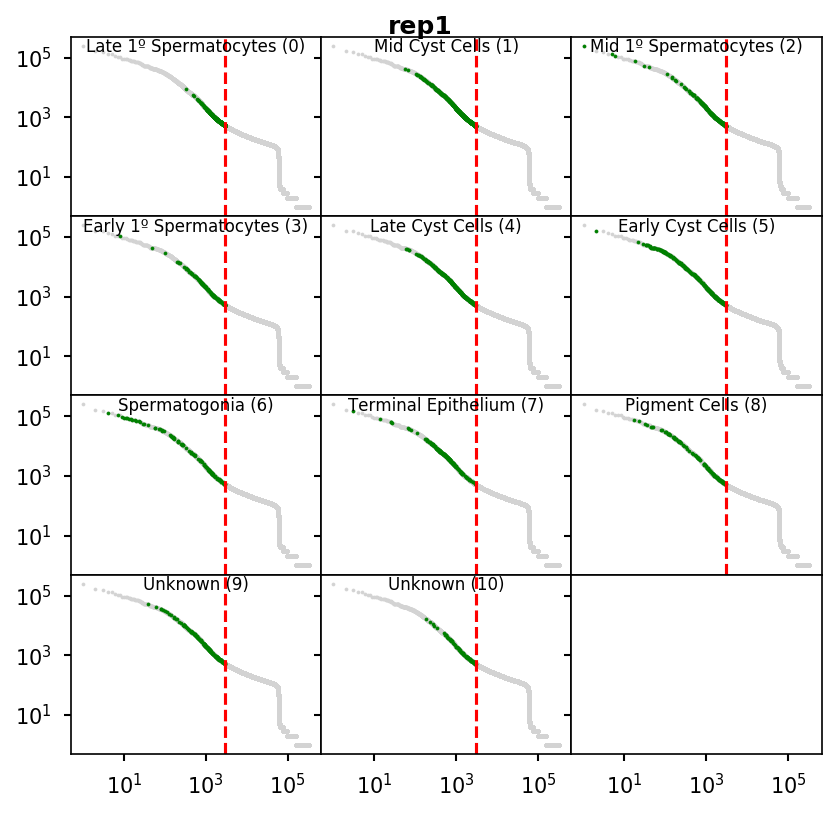

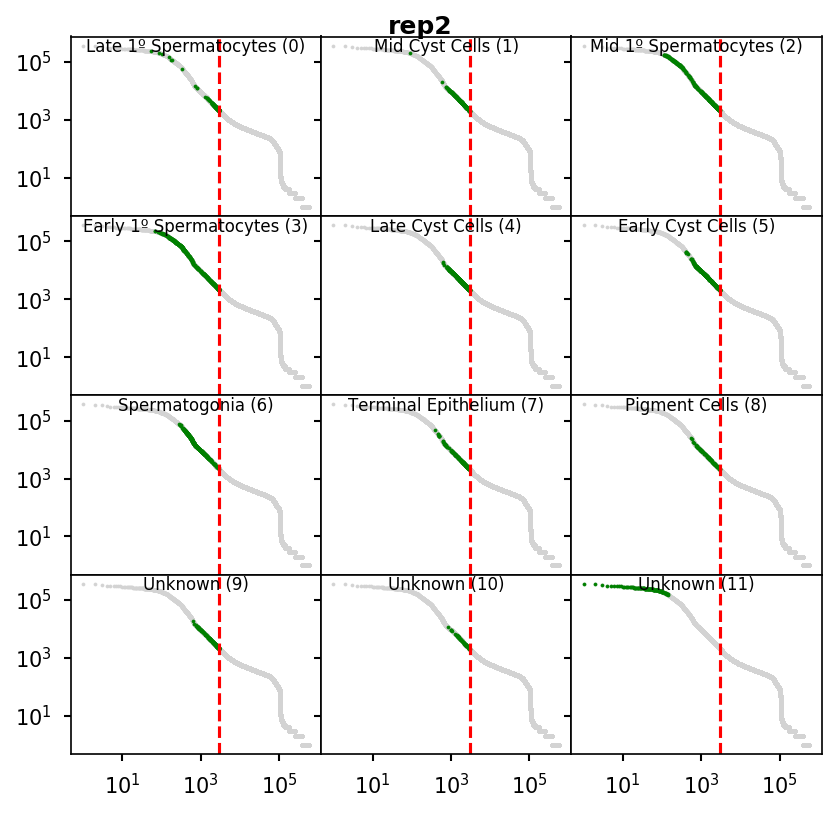

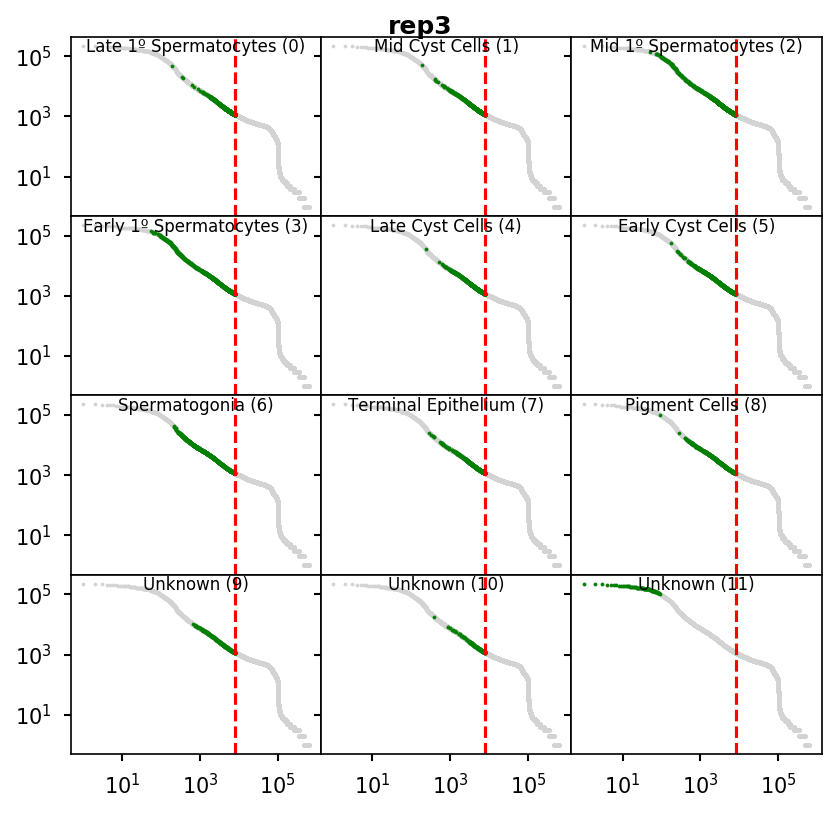

In [8]:
from larval_gonad.plotting import plot_barcode_rank
from larval_gonad.cell_selection import build_umi_gene_count_table
from larval_gonad.scRNAseq import CLUSTER_ANNOT

for name, cr_cutoff in zip(names, cellranger_cutoffs):
    rep = 'rep' + name[-1]
    
    clus = clusters.query(f'rep == "{rep}"').copy()
    clus.set_index('barcode', inplace=True)
    clus.drop('rep', axis=1, inplace=True)
    
    df = build_umi_gene_count_table(cr_raw.format(name=name), cr_umi.format(name=name))
    
    # Plots
    fig, axes = plt.subplots(4, 3, sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
    for (c, dd), ax in zip(clus.groupby('cluster'), axes.flatten()):
        sel = dd.index.tolist()
        plot_barcode_rank(df.umi_cnt, selected=sel, ax=ax)
        ax.axvline(cr_cutoff, c='r', ls='--')
        ax.text(0.5, .99, CLUSTER_ANNOT[c], ha='center', va='top', transform=ax.transAxes, fontsize=8)
        
    fig.suptitle(rep, fontsize=12, y=.92)
    [x.set_ylabel('') for x in axes[:, 0]]
    [x.set_xlabel('') for x in axes[-1, :]]
    plt.tight_layout(rect=[0, 0, 1, .95])

### Downsample

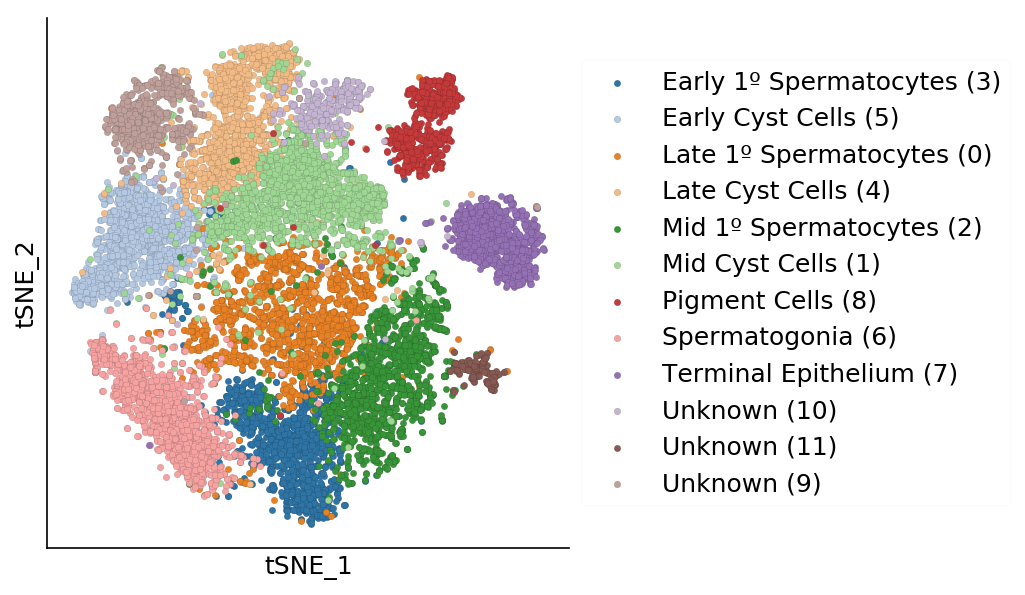

In [59]:
from larval_gonad.scRNAseq import CLUSTER_ANNOT
from larval_gonad.plotting import TSNEPlot
colors = sns.color_palette('tab20', n_colors=12, desat=.8)
tsne = nbconfig.seurat.get_tsne()
clusters = nbconfig.seurat.get_clusters()['res.0.6']
clusters.name = 'cluster'
dat = tsne.join(clusters)
dat.cluster.replace(CLUSTER_ANNOT, inplace=True)
TSNEPlot(data=dat, hue='cluster', palette=colors, s=10)
ax = plt.gca()
ax.set_aspect('equal')
sns.despine()
plt.tight_layout(rect=[0, 0, .7, 1])

In [68]:
from glob import glob

dfs = []
for fname in glob('../output/scrnaseq_combine_force_downsample/clusters_*.tsv'):
    name = 'ds' + Path(fname).stem.split('_')[1]
    df = pd.read_csv(fname, sep='\t')
    df.columns = [name]
    dfs.append(df[name])

down = pd.concat(dfs, sort=True, axis=1)

cols = ['ds0.05', 'ds0.1', 'ds0.2', 'ds0.4', 'ds0.6', 'ds0.8', 'ds1']
down = down[cols].copy()
down = down.join(clusters, how='outer')

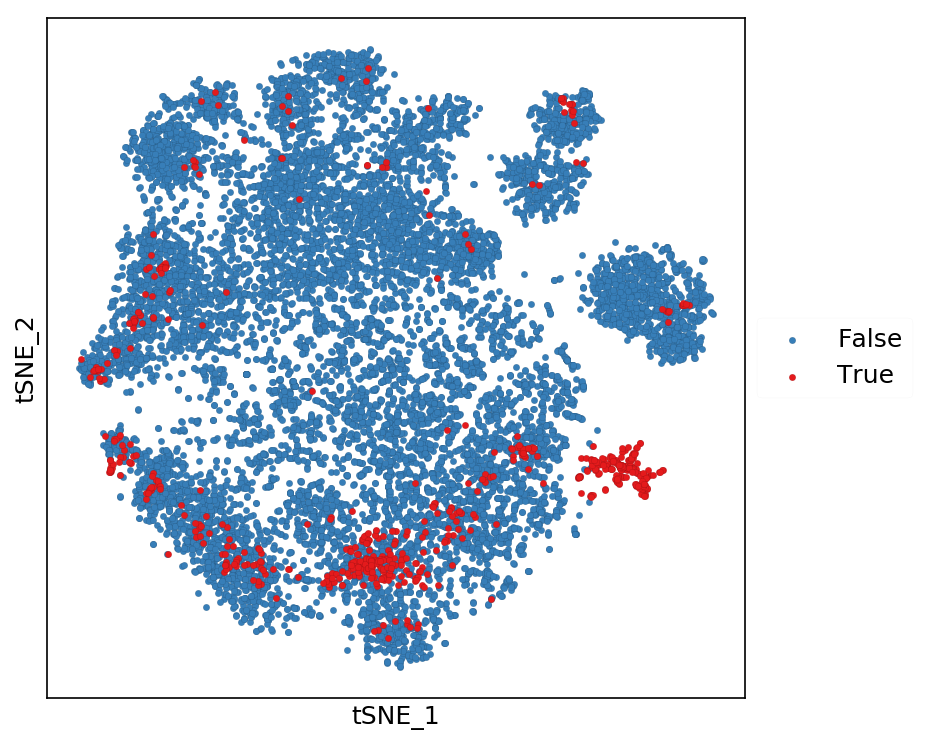

In [85]:
_on = down['ds0.05'].dropna().index.tolist()
dat['on'] = False
dat.loc[dat.index.isin(_on), 'on'] = True
TSNEPlot(data=dat, hue='on', s=10)

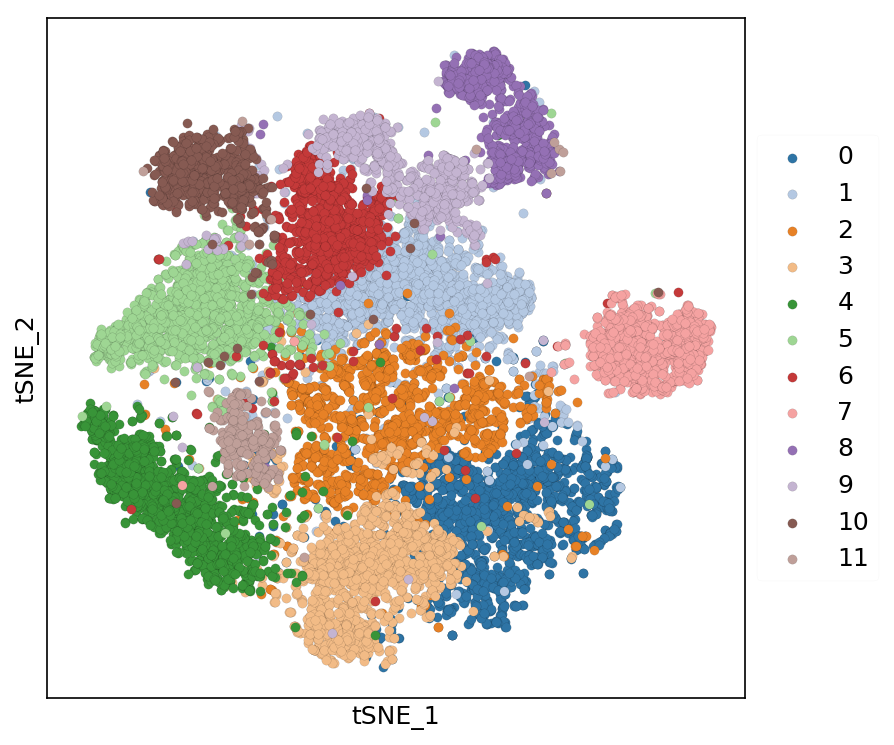

In [113]:
d1T = pd.read_csv('../output/scrnaseq_combine_force_downsample/tsne_1.tsv', sep='\t')
new = d1T.join(down['ds1'])
TSNEPlot(data=new, hue='ds1', palette=colors)

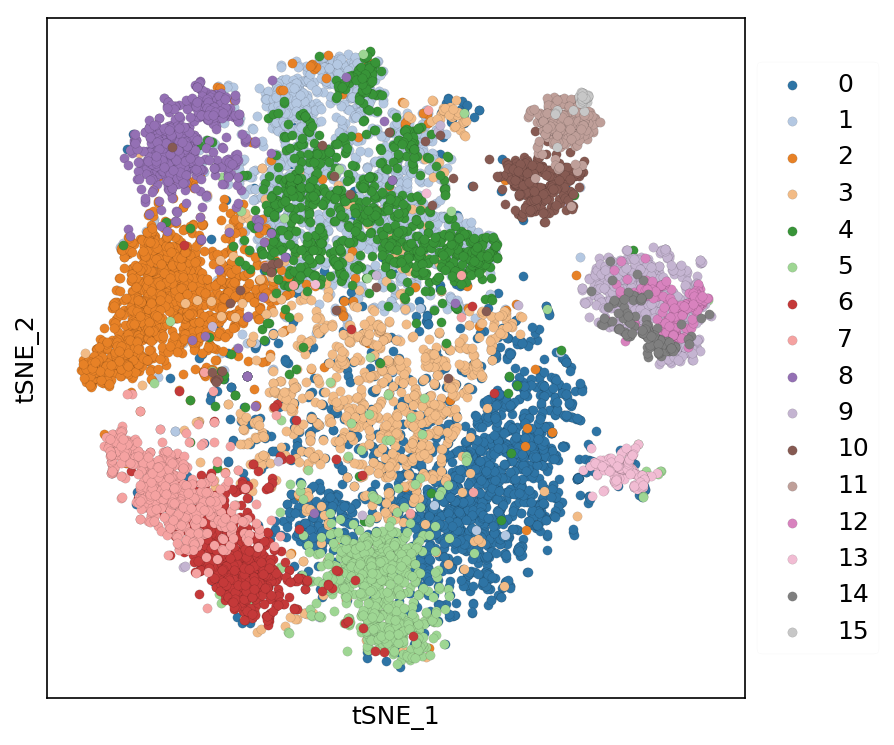

In [150]:
nc = pd.read_csv('../output/scrnaseq_combine_force_downsample/clusters_0.8.tsv', sep='\t')
nc.columns = ['cluster1']
TSNEPlot(data=dat.join(nc, how='inner'), hue='cluster1', palette=sns.color_palette('tab20', n_colors=20, desat=.8))

In [ ]:
res = []
for col in cols:
    ts = down[[col, 'cluster']].dropna()
    for clus, dd in ts.groupby('cluster'):
        for c1, c2 in combinations(dd.index.tolist(), 2):
            v1, v2 = dd.loc[[c1, c2], col].values
            if v1 == v2:
                res.append((col, clus, True))
            else:
                res.append((col, clus, False))

In [ ]:
resDf = pd.DataFrame(res, columns=['ds', 'cluster', 'same']

In [ ]:
resDf.head()

In [173]:
one = ts.query('cluster == 1')

In [178]:
from itertools import combinations

array([ 1.,  1.])

In [63]:
def count_stuff(dat, ds):
    _dat = pd.concat([dat[ds].dropna(), clusters], join='inner', axis=1)
    
    dfs = []
    for g, dd in _dat.groupby(ds):
        cnts = dd.cluster.value_counts().to_frame().reset_index()
        cnts.columns = ['cluster', 'count']
        cnts['curr_cluster'] = g
        dfs.append(cnts)

    dat2 = pd.concat(dfs).groupby('curr_cluster').size().to_frame()
    dat2.columns = ['num_clusters']
    dat2['ds'] = ds
    return dat2

In [66]:
dfs = []
for c in cols:
    dfs.append(count_stuff(dat, c))

In [67]:
dfs

[              num_clusters      ds
 curr_cluster                      
 0.0                      6  ds0.05
 1.0                      3  ds0.05
 2.0                     10  ds0.05
 3.0                      6  ds0.05
 4.0                     10  ds0.05
 5.0                     10  ds0.05
 6.0                      5  ds0.05,               num_clusters     ds
 curr_cluster                     
 0.0                      9  ds0.1
 1.0                      5  ds0.1
 2.0                      8  ds0.1
 3.0                     10  ds0.1
 4.0                      5  ds0.1
 5.0                      4  ds0.1
 6.0                     11  ds0.1
 7.0                      9  ds0.1
 8.0                      6  ds0.1,               num_clusters     ds
 curr_cluster                     
 0.0                      9  ds0.2
 1.0                      5  ds0.2
 2.0                      7  ds0.2
 3.0                      5  ds0.2
 4.0                      6  ds0.2
 5.0                      7  ds0.2
 6.0       

### Protein Traps Heatmap

In [5]:
import yaml

from larval_gonad.scRNAseq import CLUSTER_ANNOT, CLUSTER_ORDER

clusters = nbconfig.seurat.get_clusters()['res.0.6']
clusters.name = 'cluster'
clusters.replace(CLUSTER_ANNOT, inplace=True)

norm = nbconfig.seurat.get_normalized_read_counts()
dat = norm.T.join(clusters).groupby('cluster').sum().T[CLUSTER_ORDER]

# Get lit supported genes
with open('../paper_submission/config.yaml') as fh:
    config = yaml.load(fh)

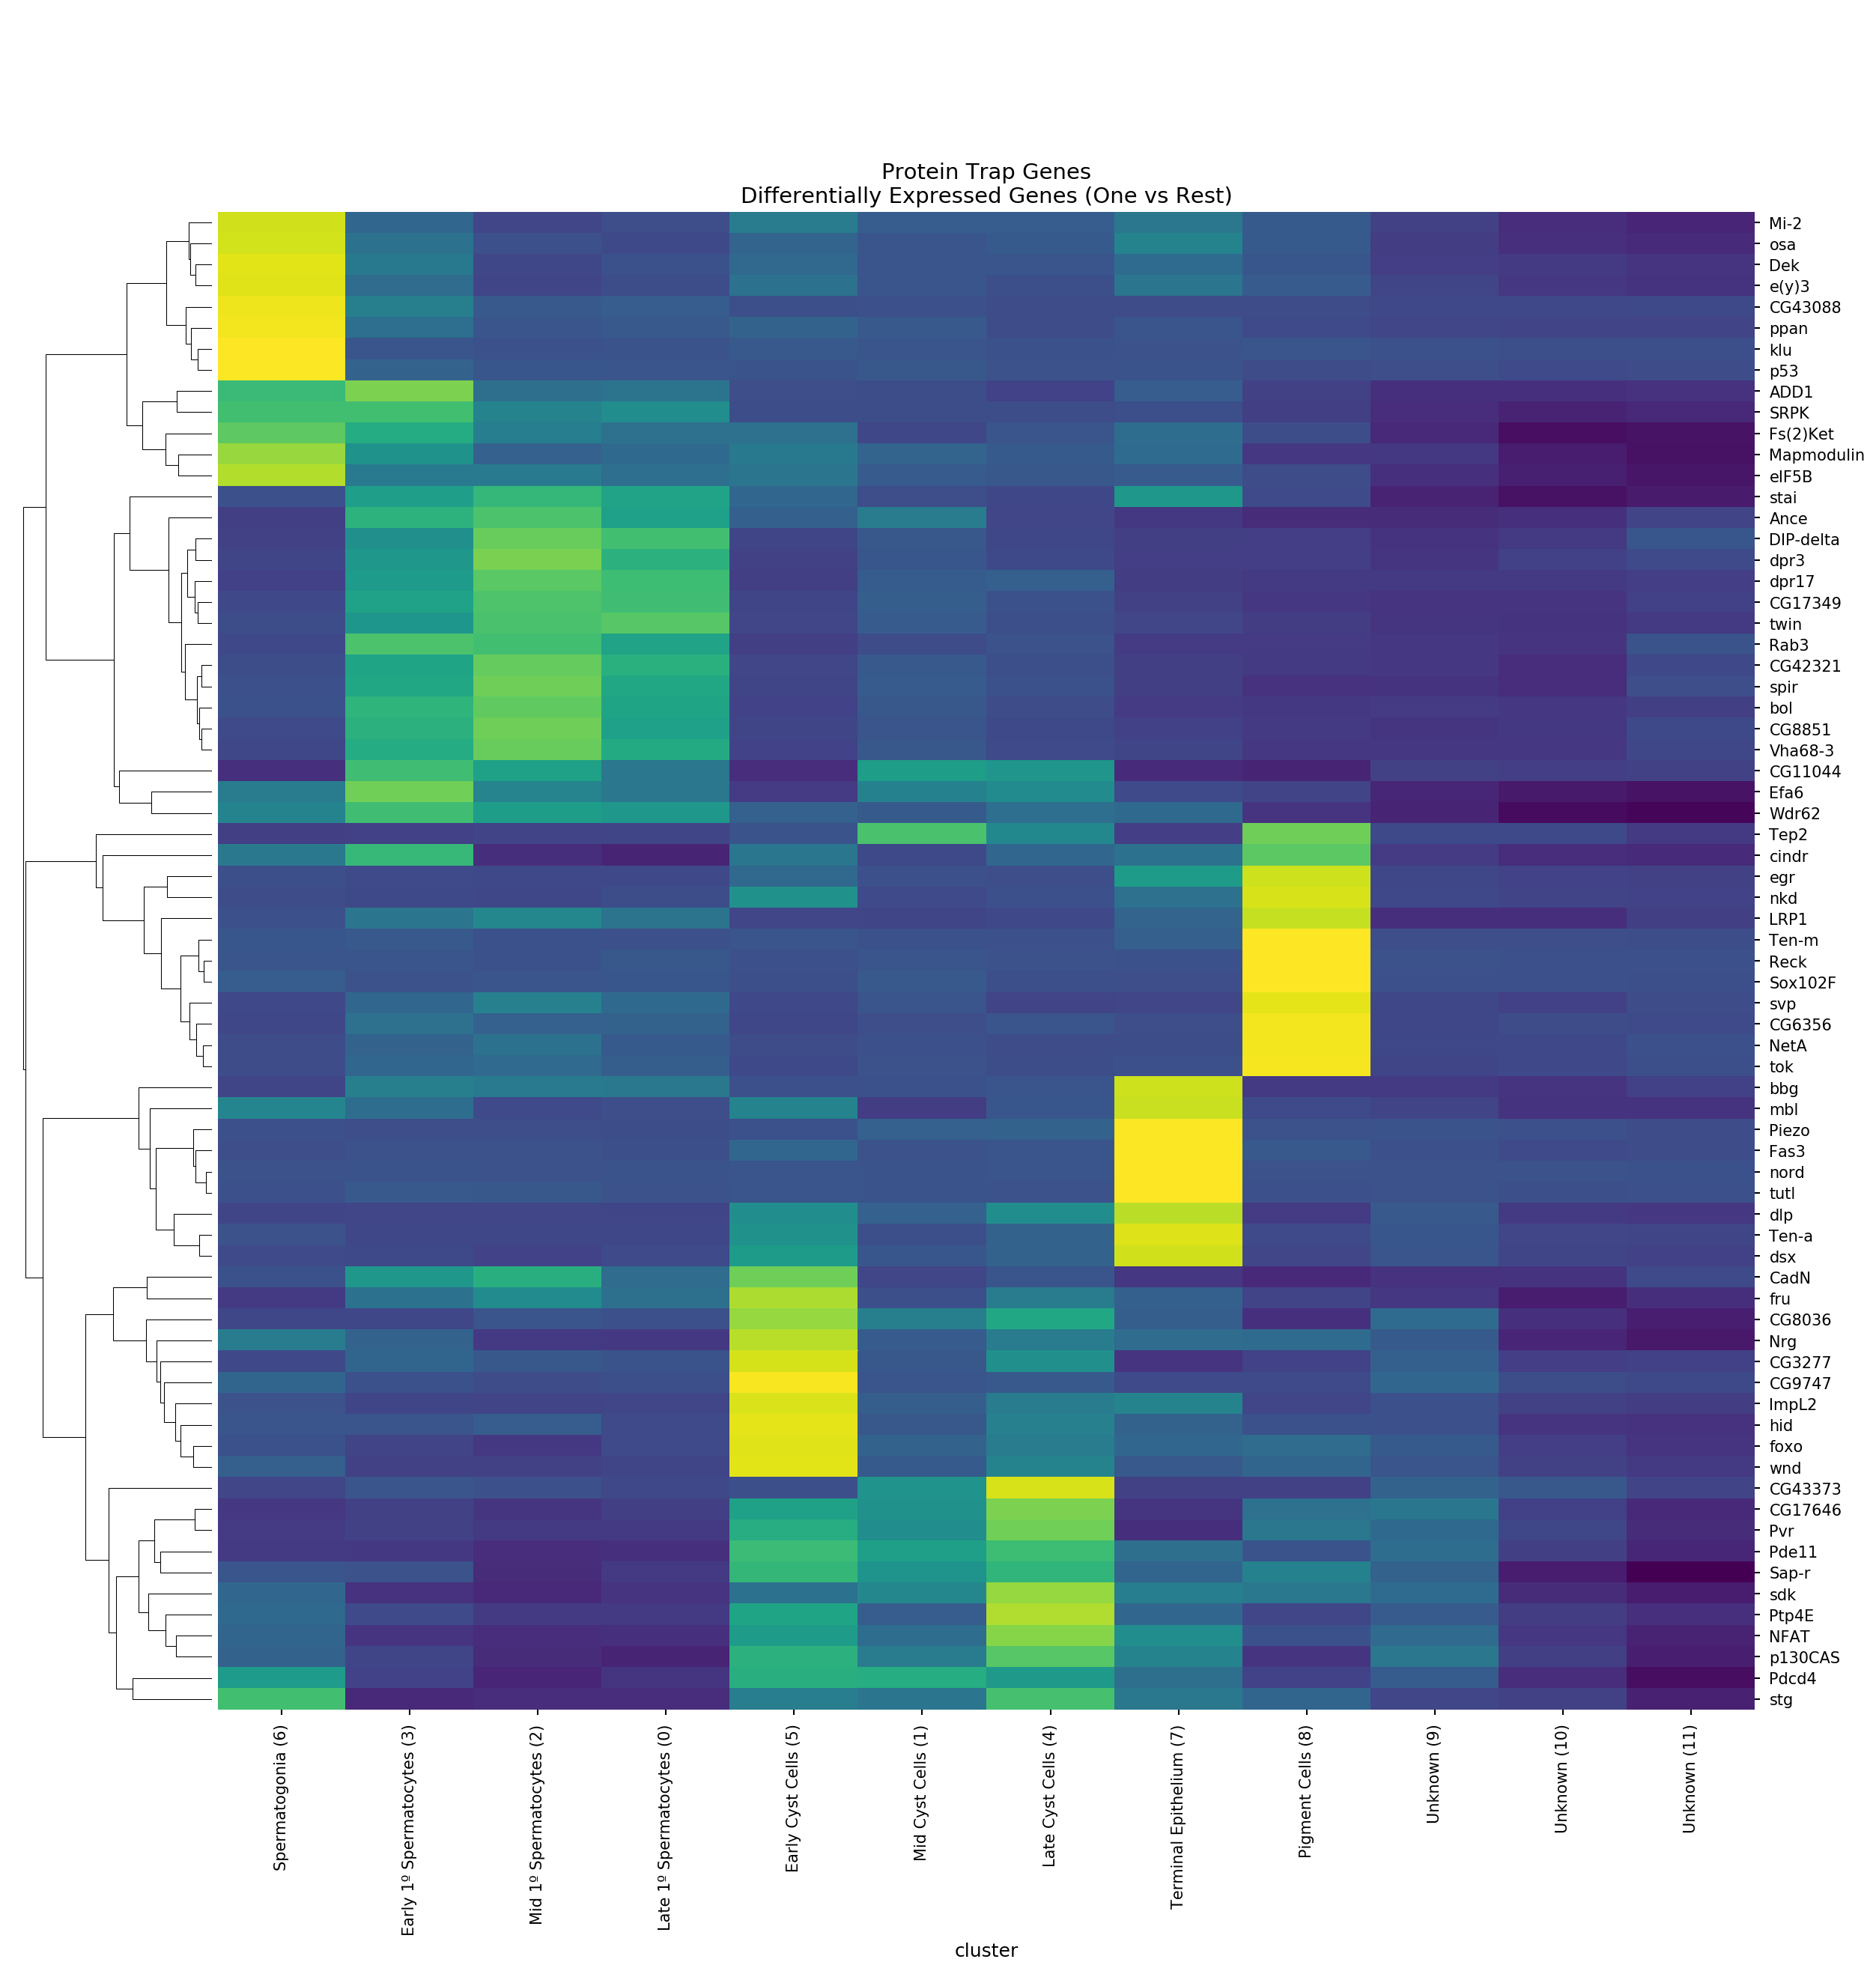

In [8]:
select = [nbconfig.symbol2fbgn[g] for g in config['protein_trap_genes']]

g = sns.clustermap(
  dat.loc[select],
  col_cluster=False,
  row_cluster=True,
  z_score=0,
  cmap='viridis',
  rasterized=False,
  figsize=(20, 20),

)

ax = g.ax_heatmap
new_labels = []
for l in ax.get_yticklabels():
    new_labels.append(nbconfig.fbgn2symbol[l.get_text()])

ax.set_yticklabels(new_labels)
ax.set_title('Protein Trap Genes\nDifferentially Expressed Genes (One vs Rest)')
g.cax.set_visible(False)

### Get Gene Locations on X

In [113]:
import gffutils

In [114]:
db = gffutils.FeatureDB('/data/LCDB/lcdb-references/dmel/r6-16/gtf/dmel_r6-16.gtf.db')

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/gffutils/interface.py:161: UserWarning: It appears that this database has not had the ANALYZE sqlite3 command run on it. Doing so can dramatically speed up queries, and is done by default for databases created with gffutils >0.8.7.1 (this database was created with version 0.8.7.1) Consider calling the analyze() method of this object.
  "method of this object." % self.version)


In [115]:
locs = []
for gene in db.features_of_type('gene'):
    _id = gene.id
    chrom = gene.chrom
    start = gene.start
    end = gene.end
    strand = gene.strand
    if start < end:
        pos = start
    else:
        pos = end
    locs.append((_id, chrom, pos, strand))

In [117]:
geneLoc = pd.DataFrame(locs, columns=['FBgn', 'chrom', 'position', 'strand'])
geneLoc.set_index('FBgn', inplace=True)
geneLoc.sort_values(['chrom', 'position'], inplace=True)

### Images by Chromosome Arm

In [3]:
norm = nbconfig.seurat.get_normalized_read_counts()

clusters = nbconfig.seurat.get_clusters()['res.0.6']
clusters.name = 'cluster'

norm_clus = norm.T.join(clusters)

In [50]:
colors = sns.color_palette('tab20', n_colors=12, desat=.8)
cmap = {k: v for k, v in zip(range(12), colors)}

In [13]:
_sum = norm_clus.groupby('cluster').sum().T
_med = norm_clus.groupby('cluster').median().T

res = []
for g, dd in norm_clus.groupby('cluster'):
    _on = (dd > 0).sum() / dd.shape[0]
    _on.name = g
    res.append(_on)
    
_frac_on = pd.concat(res, axis=1)

In [321]:
def plot_chrom_pos(df, chrom, ylabel='Total Normalized Read Counts\n(20 Gene Window)'):
    fig, (ax1, ax2) = plt.subplots(2, 1,
                                   figsize=plt.figaspect(1/2), 
                                   sharex=True, 
                                   sharey=True,
                                   gridspec_kw={'hspace': 0}
                                  )

    for g, dd in df.T.groupby('cluster'):
        if g in [9, 10, 11]:
            continue
        elif g in [1, 4, 5, 7, 8]:
            ax = ax2
        else:
            ax = ax1
        dat = dd.T.join(geneLoc).fillna(0).query(f'chrom == "{chrom}"').copy().sort_values('position')
        roll = dat[g].rolling(20).sum()[20 - 1::20].to_frame().join(geneLoc)
        roll.plot('position', g, label=CLUSTER_ANNOT[g], ax=ax, color=cmap[g])

    #ax1.legend(loc='center right', bbox_to_anchor=[1.2, .5])
    #ax2.legend(loc='center right', bbox_to_anchor=[1.2, .5])

    ax1.set_xlabel('')
    ax2.set_xlabel(f'{chrom} Position (bp)')

    ax1.set_ylabel('')
    ax2.set_ylabel('')

    fig.text(0, 0.5, ylabel, 
             transform=fig.transFigure, 
             rotation=90,
             ha='center',
             va='center'
            )
    plt.tight_layout()

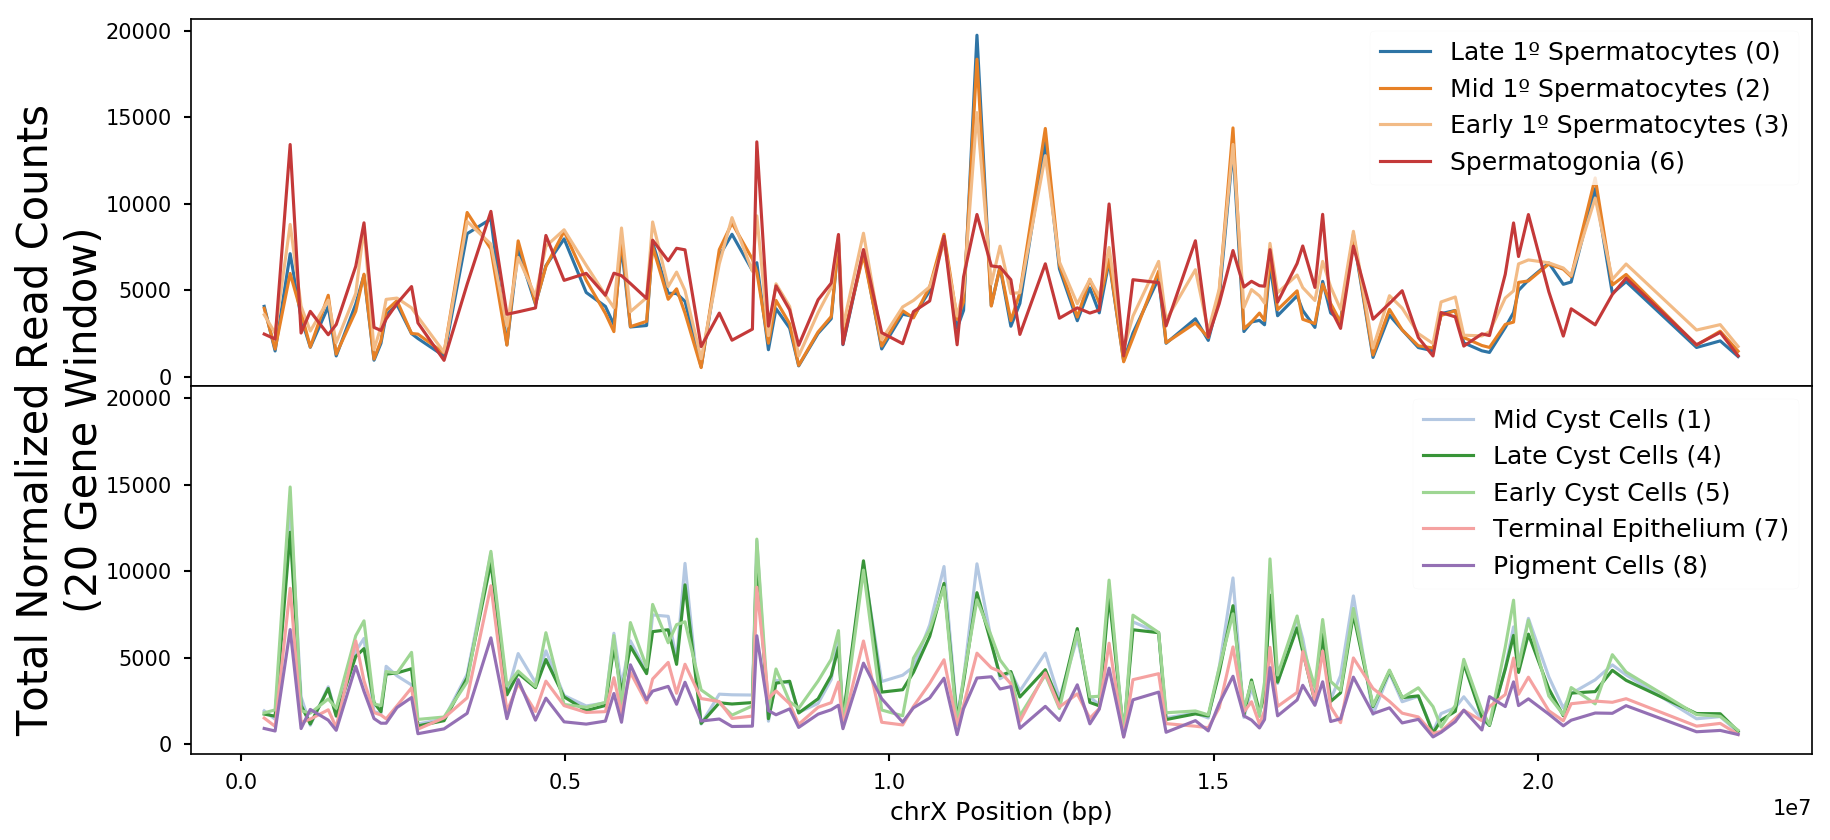

In [322]:
plot_chrom_pos(_sum, 'chrX')

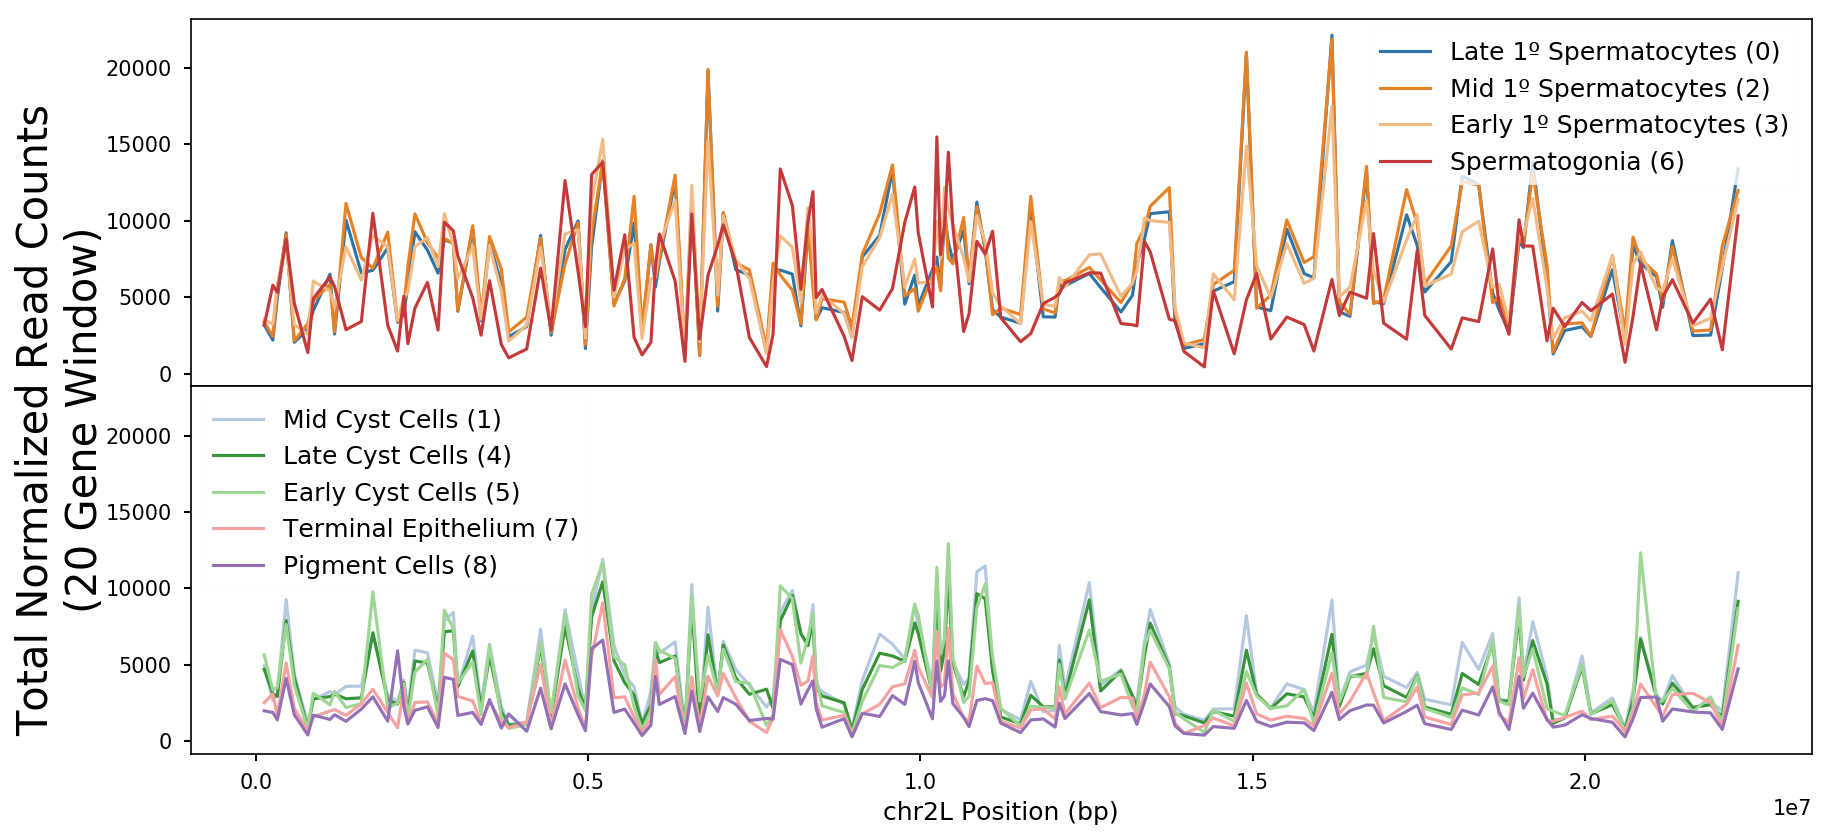

In [323]:
plot_chrom_pos(_sum, 'chr2L')

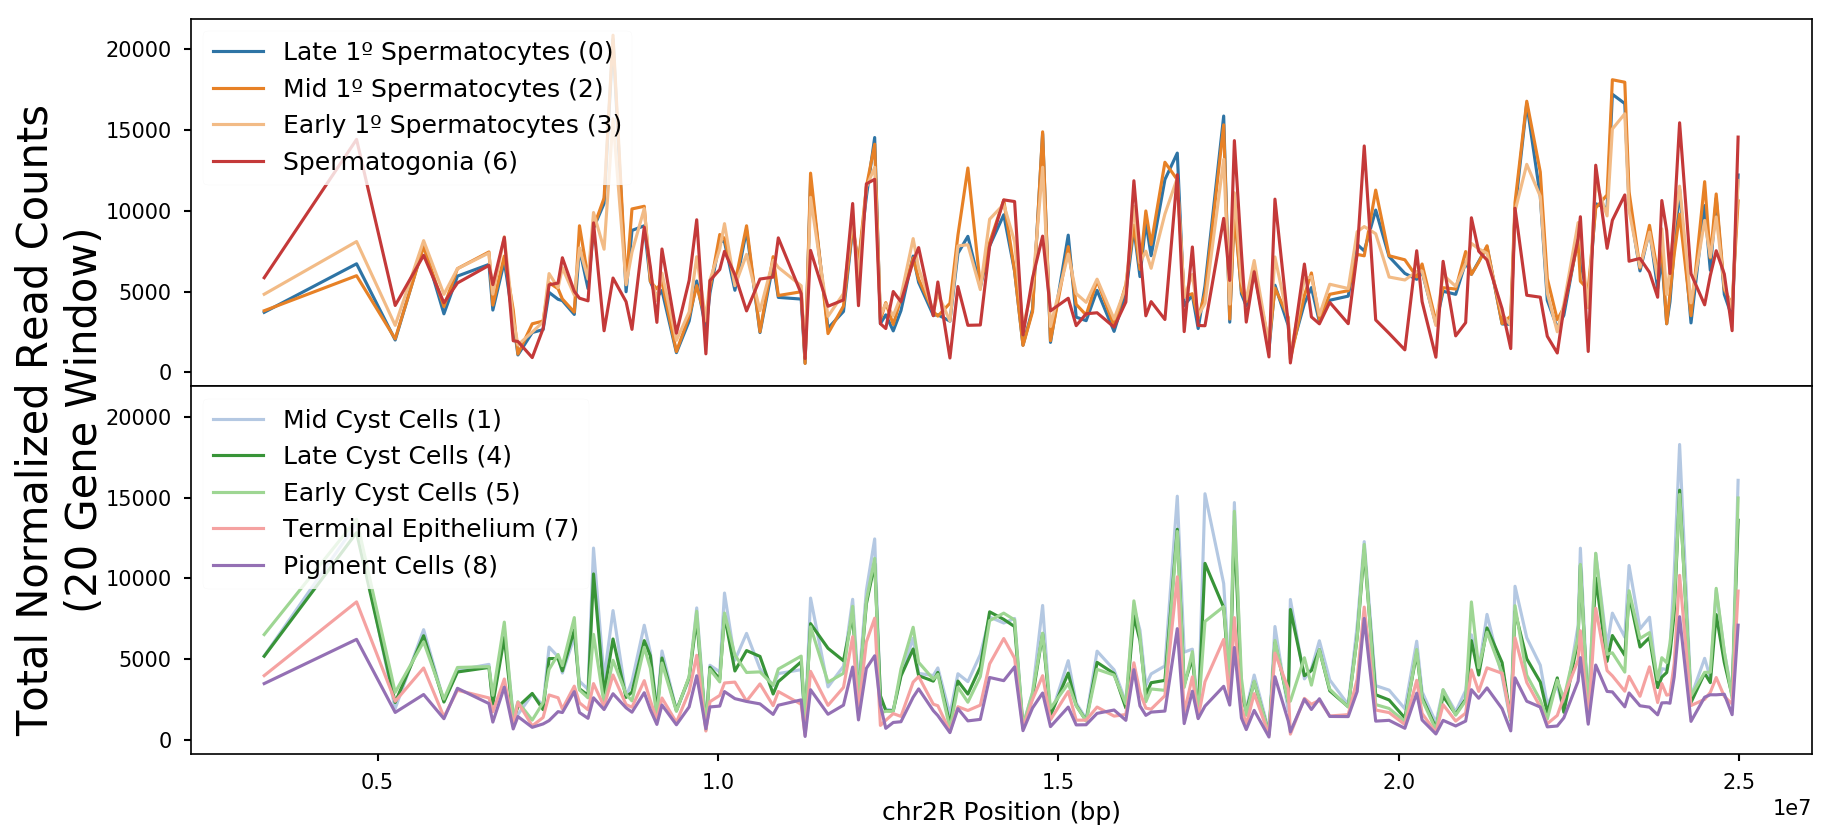

In [324]:
plot_chrom_pos(_sum, 'chr2R')

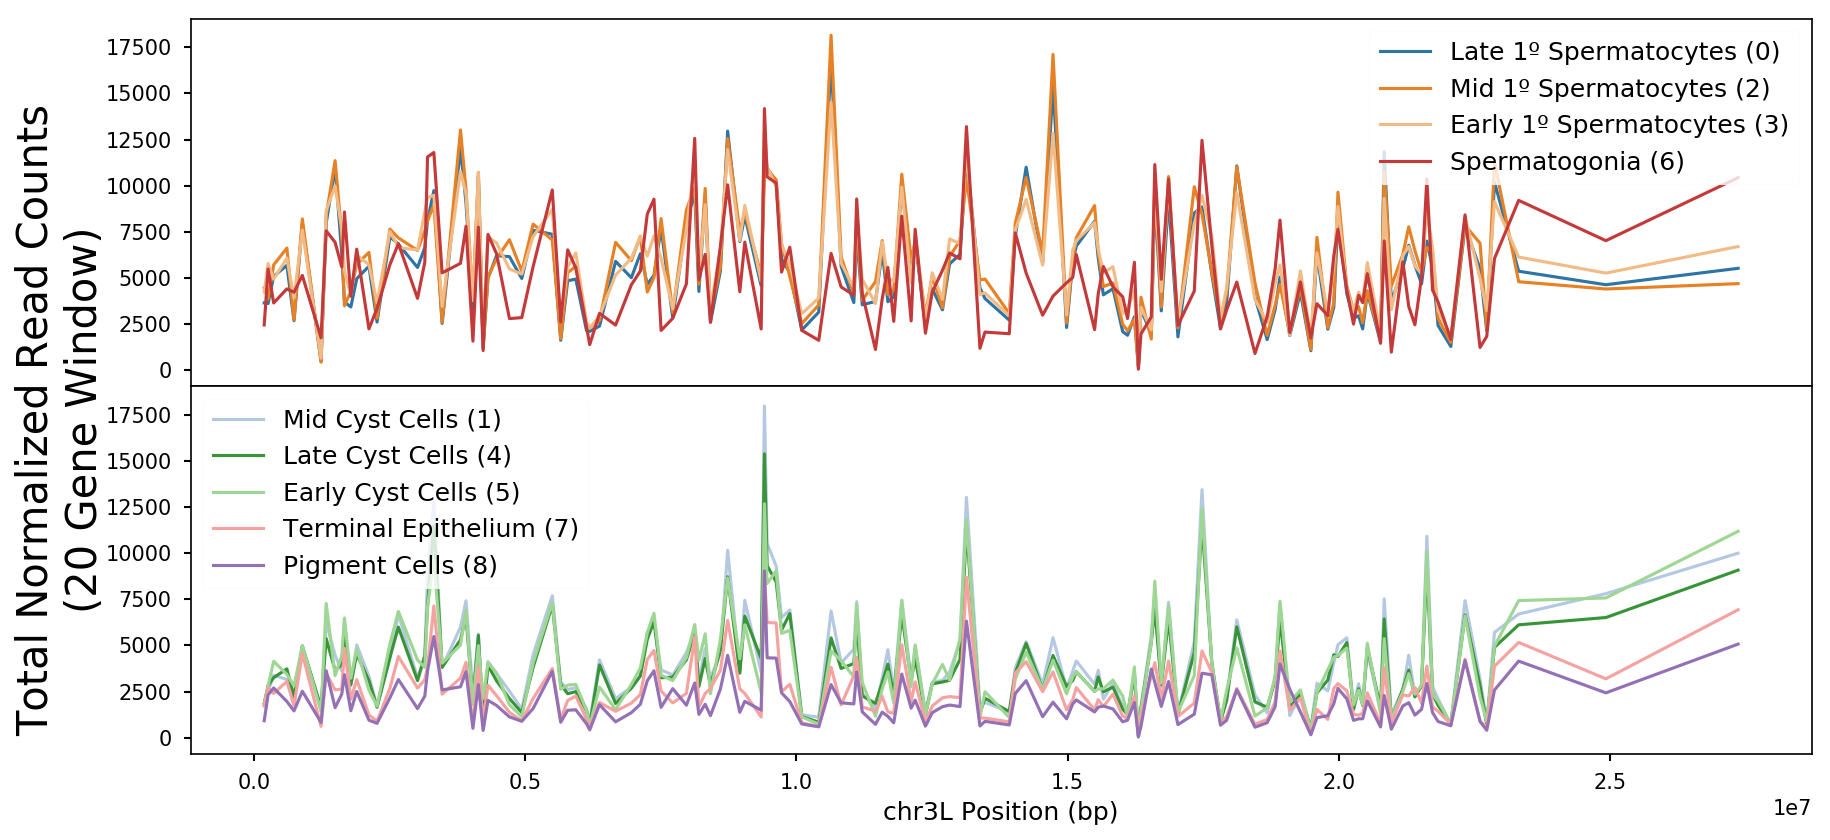

In [325]:
plot_chrom_pos(_sum, 'chr3L')

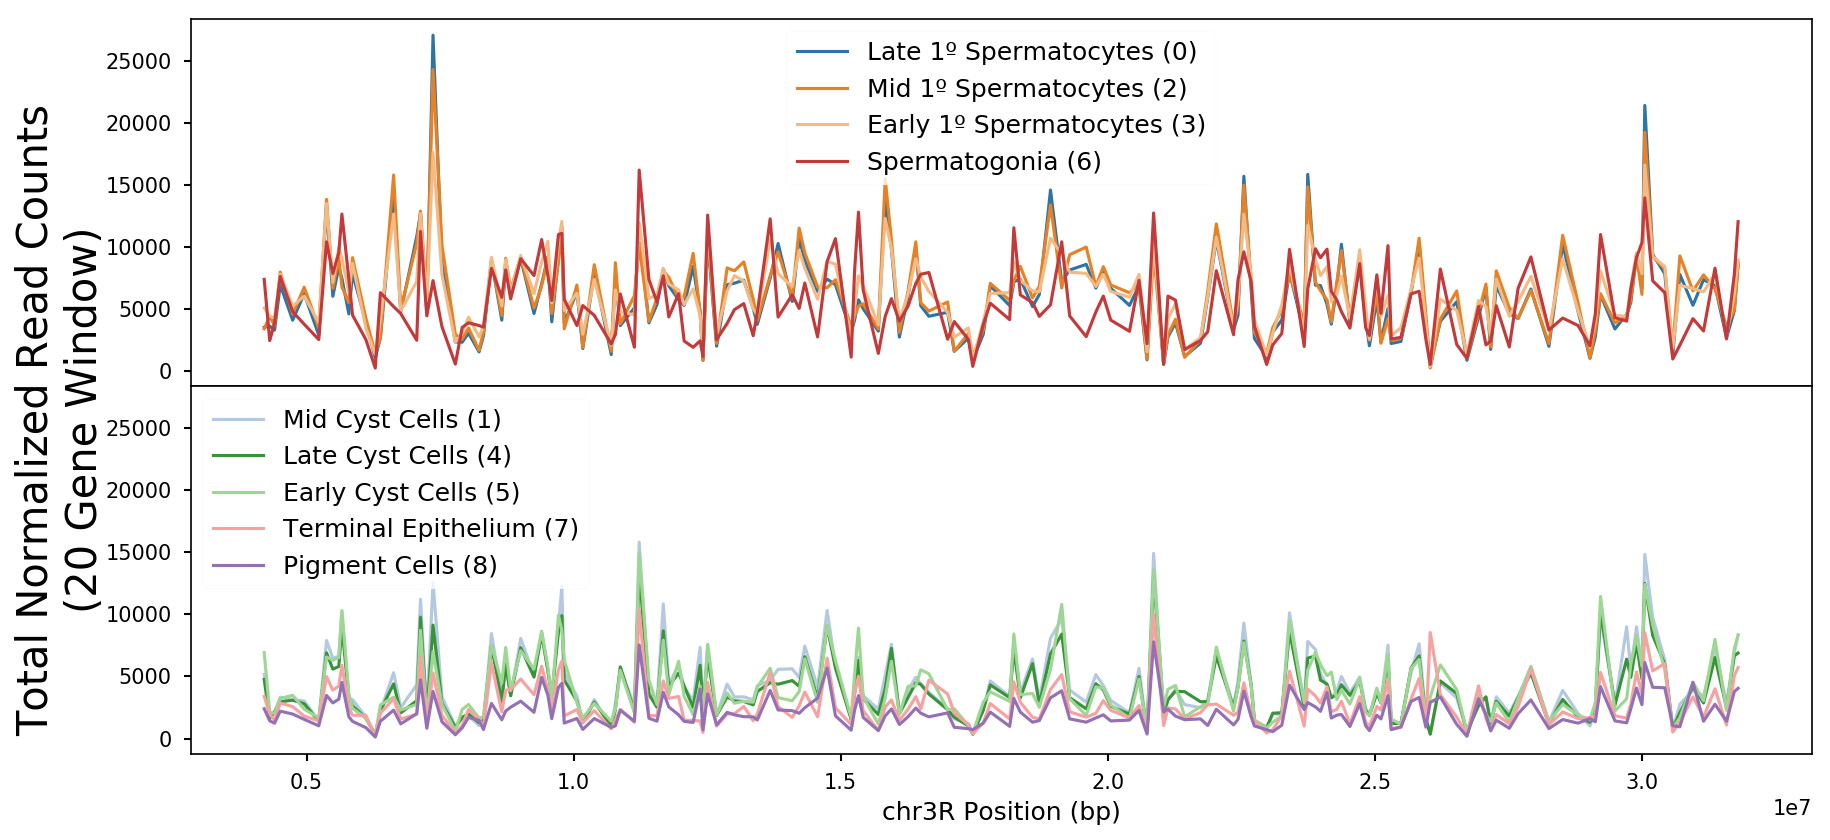

In [326]:
plot_chrom_pos(_sum, 'chr3R')

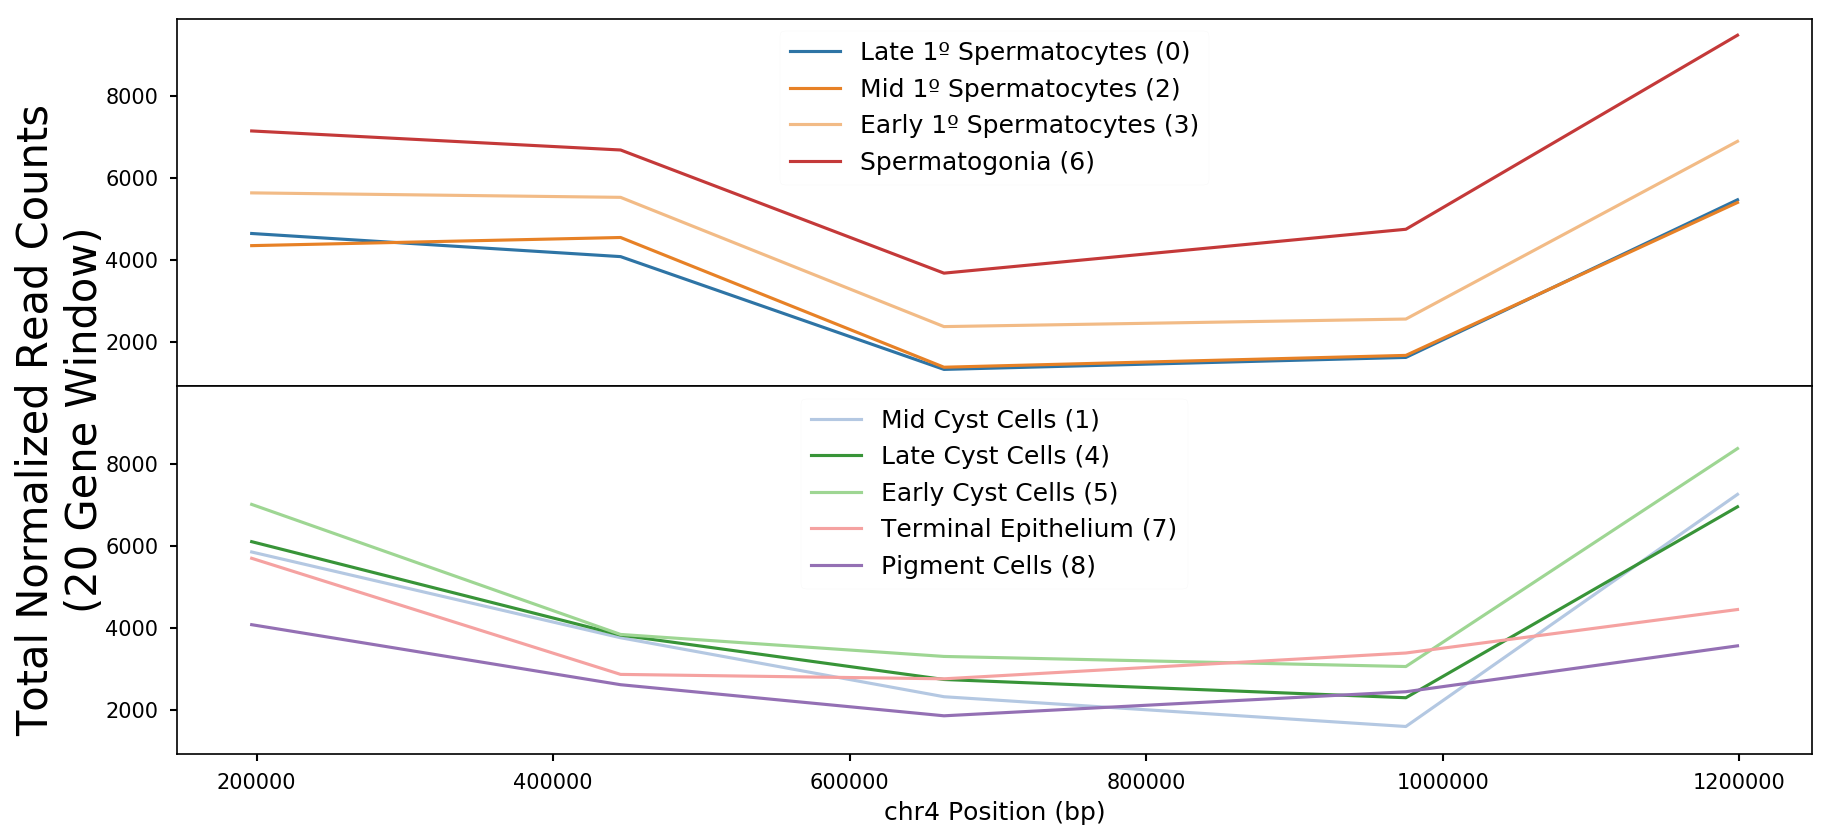

In [327]:
plot_chrom_pos(_sum, 'chr4')

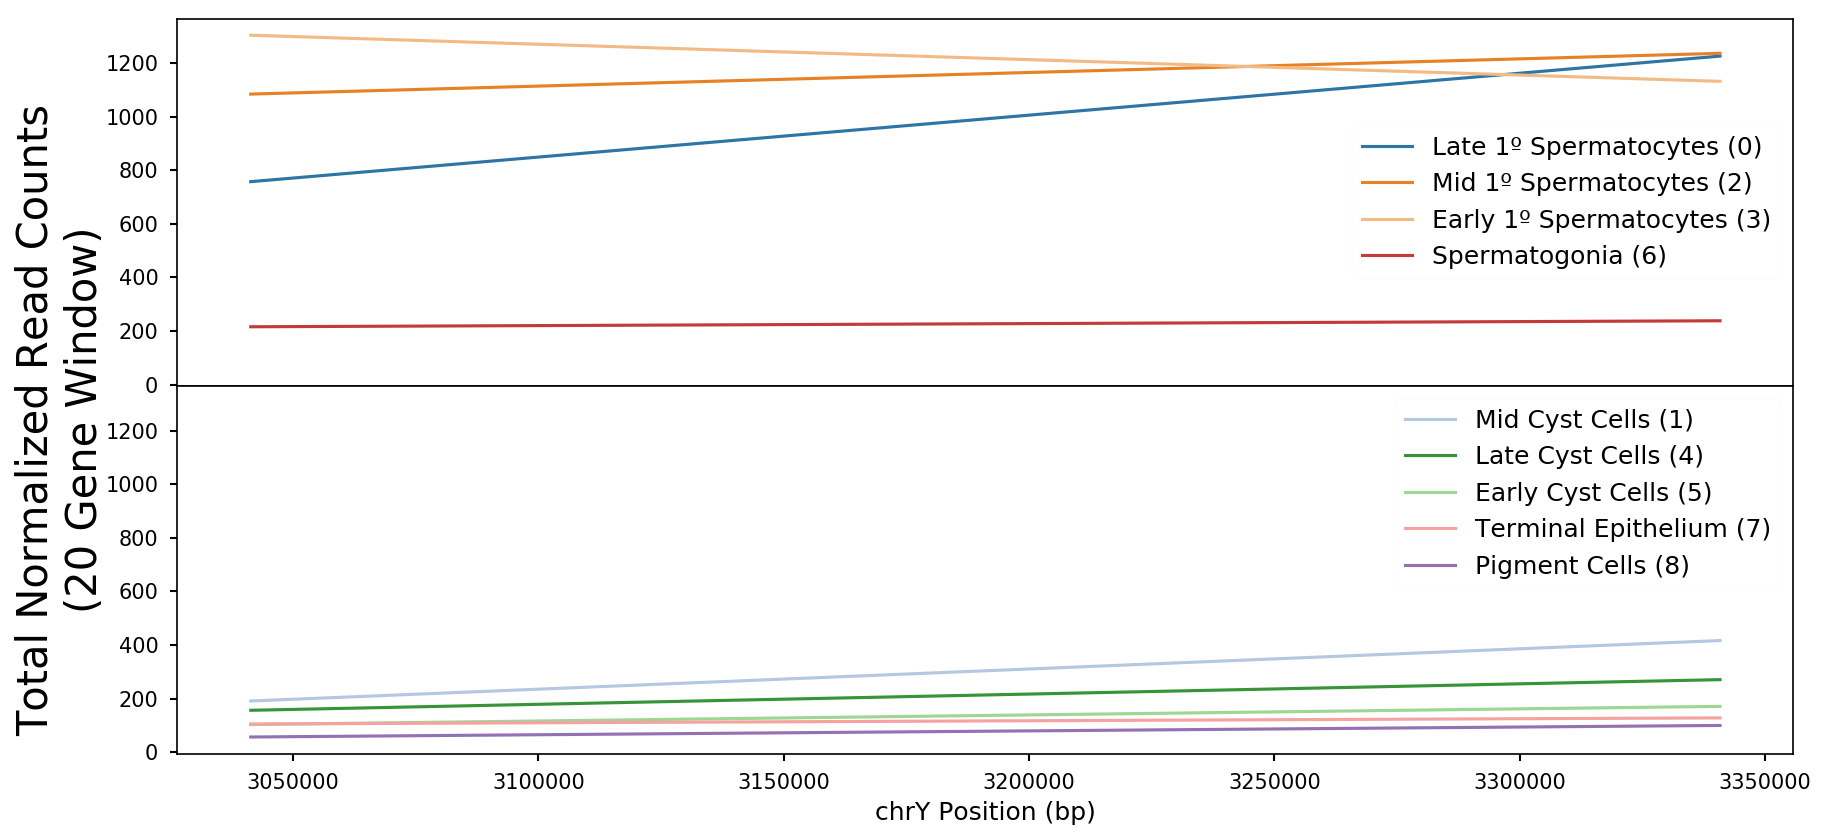

In [328]:
plot_chrom_pos(_sum, 'chrY')

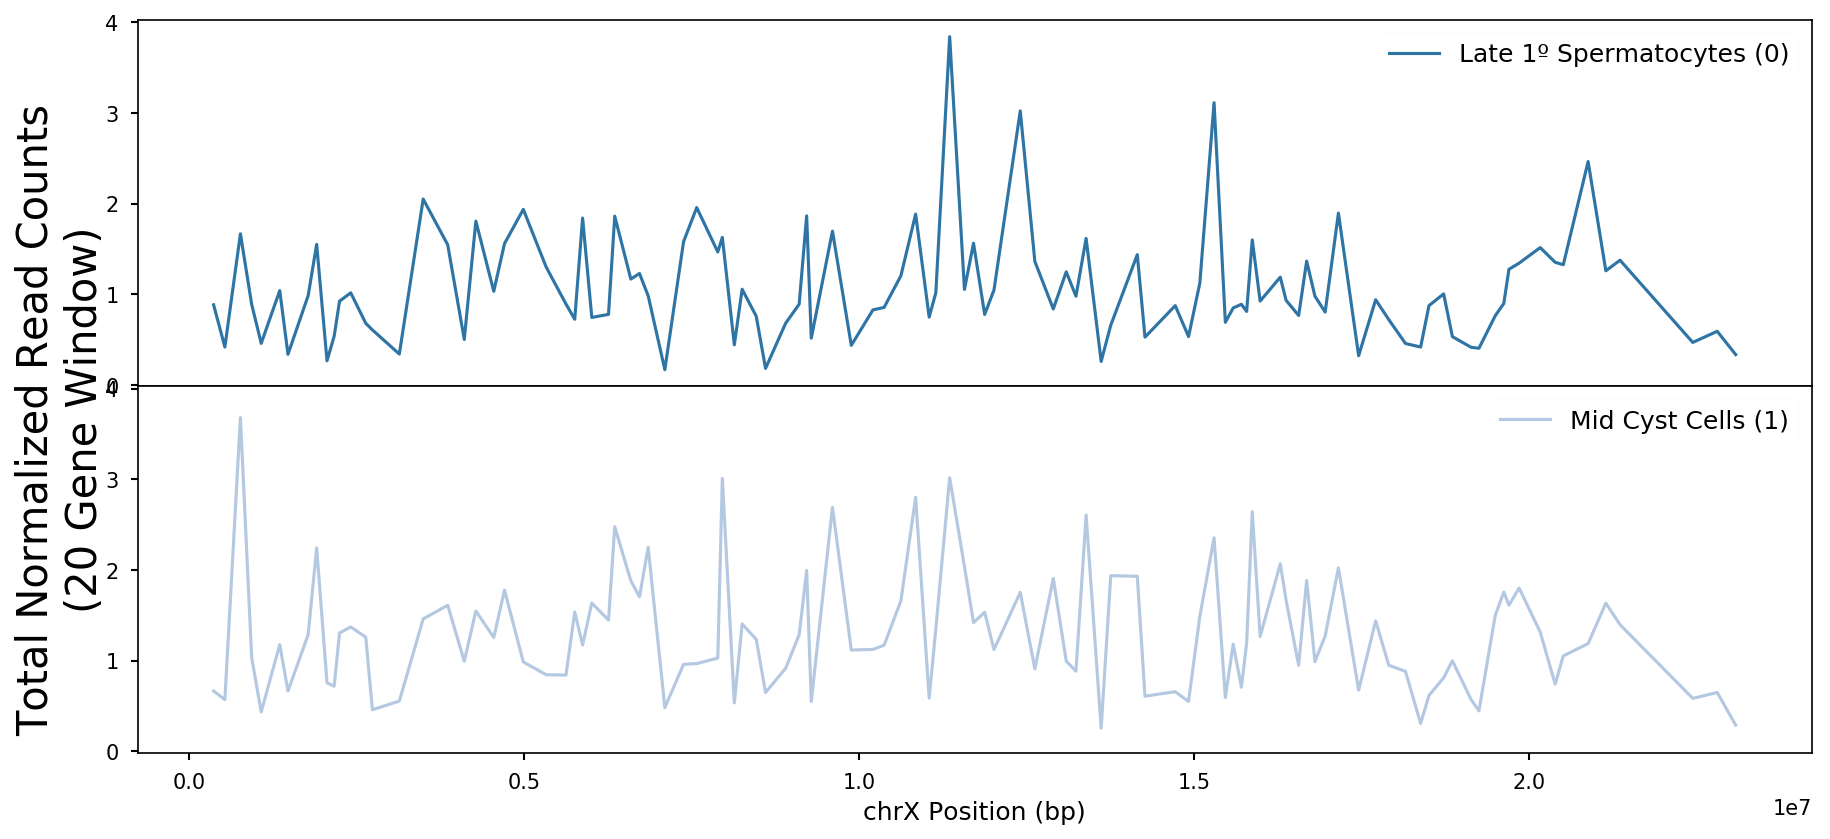

In [329]:
plot_chrom_pos(_frac_on, 'chrX')

In [277]:
raw = nbconfig.seurat.get_raw()

In [278]:
from larval_gonad.normalization import tpm

In [318]:
cbc = raw.T.join(clusters).groupby('cluster').sum().T

In [319]:
cbc.head()

cluster        0    1      2      3    4    5     6    7    8    9    10  \
FBgn0031081     2   10      4     19   33    9     4    1    0   12    4   
FBgn0031085  2343  724  12232  14214  506  443   890  254  311  208  169   
FBgn0040784   929  320   2907  10270  197  249  4736  116  123   88   54   
FBgn0031086     0    0      1     11    0    2    11    0    0    0    0   
FBgn0031082   406  157   2051   2508  109  108   222   64   63   41   41   

cluster         11  
FBgn0031081      8  
FBgn0031085  25231  
FBgn0040784   5417  
FBgn0031086      1  
FBgn0031082   4596

Text(0,0.5,'Read Counts (Log)')

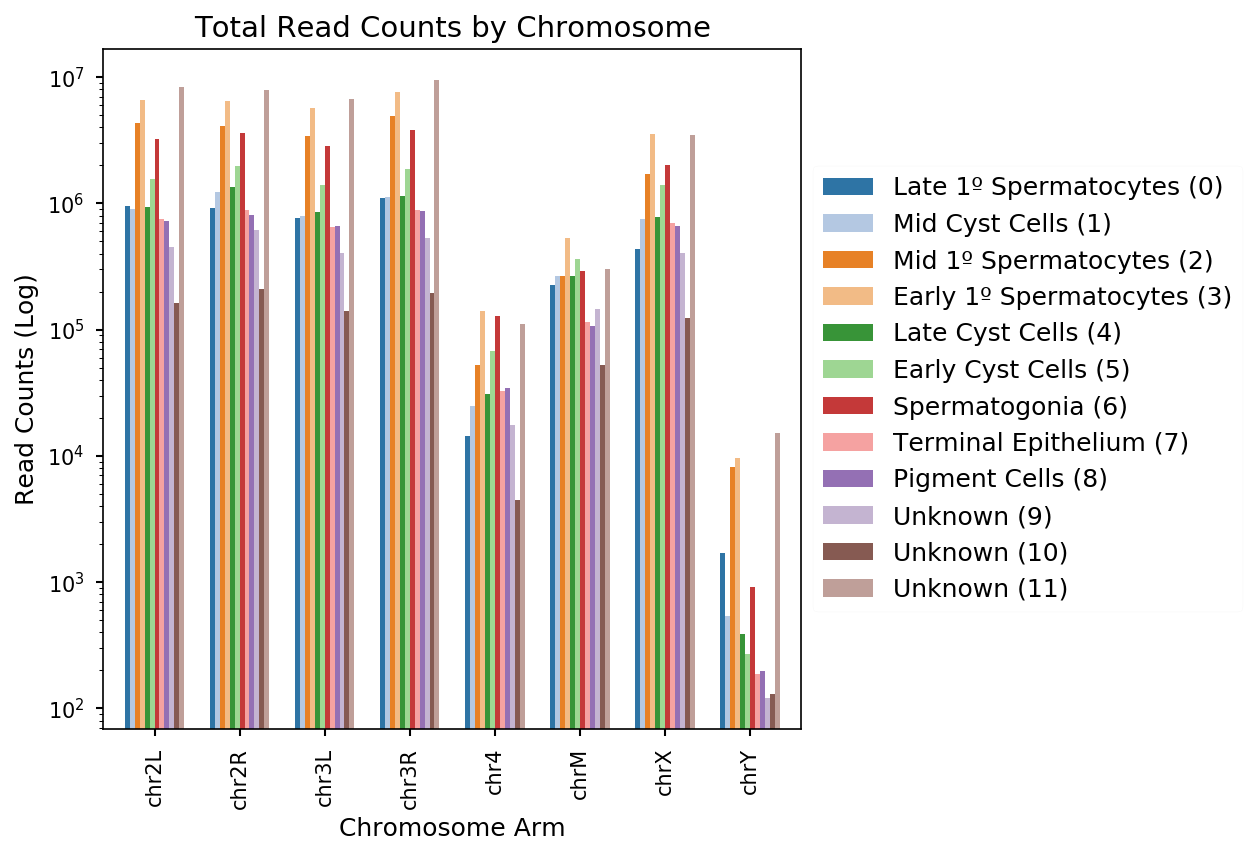

In [314]:
ax = cbc.join(nbconfig.fbgn2chrom).groupby('chrom').sum().plot(kind='bar', logy=True, color=colors, width=.7)
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5], bbox_transform=ax.transAxes)
ax.set_title('Total Read Counts by Chromosome')
ax.set_xlabel('Chromosome Arm')
ax.set_ylabel('Read Counts (Log)')

In [317]:
_sum.head()

cluster               0           1            2            3           4   \
FBgn0031081     3.922293   12.198445     5.718024     6.281694   34.545968   
FBgn0031085  2141.423896  697.935982  2396.655383  1870.803187  544.907686   
FBgn0040784  1078.392049  383.705777   979.242871  1393.871140  224.566168   
FBgn0031086     0.000000    0.000000     0.098070     2.883973    0.000000   
FBgn0031082   526.948576  181.598979   655.995203   558.443747  129.330223   

cluster              5            6           7           8           9   \
FBgn0031081    9.764831     1.364676    1.958704    0.000000   14.464338   
FBgn0031085  452.966695   481.630977  333.302469  285.161958  232.010488   
FBgn0040784  204.406475  1433.780552  169.333821  130.681355  117.852980   
FBgn0031086    2.484050     4.217180    0.000000    0.000000    0.000000   
FBgn0031082  116.979552   130.809532   88.323805   53.269968   48.154262   

cluster              10          11  
FBgn0031081    5.663631    0.384271  
FBgn0031085  222.704014  369.817387  
FBgn0040784   84.973216  153.861122  
FBgn0031086    0.000000    0.056665  
FBgn0031082   67.286299  144.788021

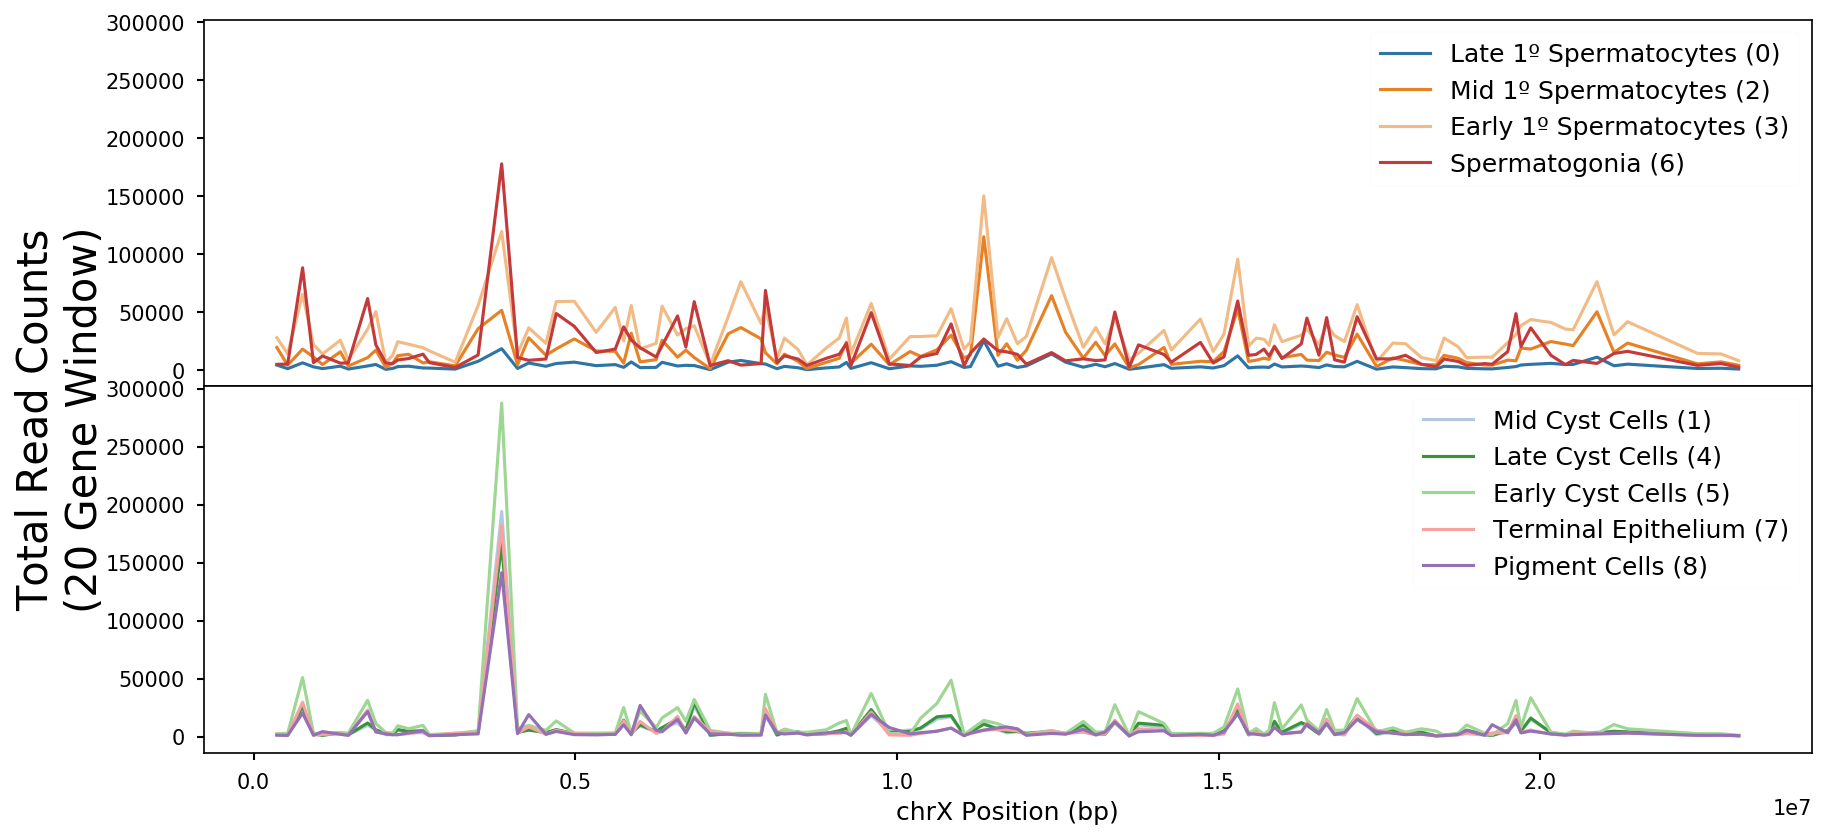

In [331]:
plot_chrom_pos(cbc, 'chrX', ylabel='Total Read Counts\n(20 Gene Window)')

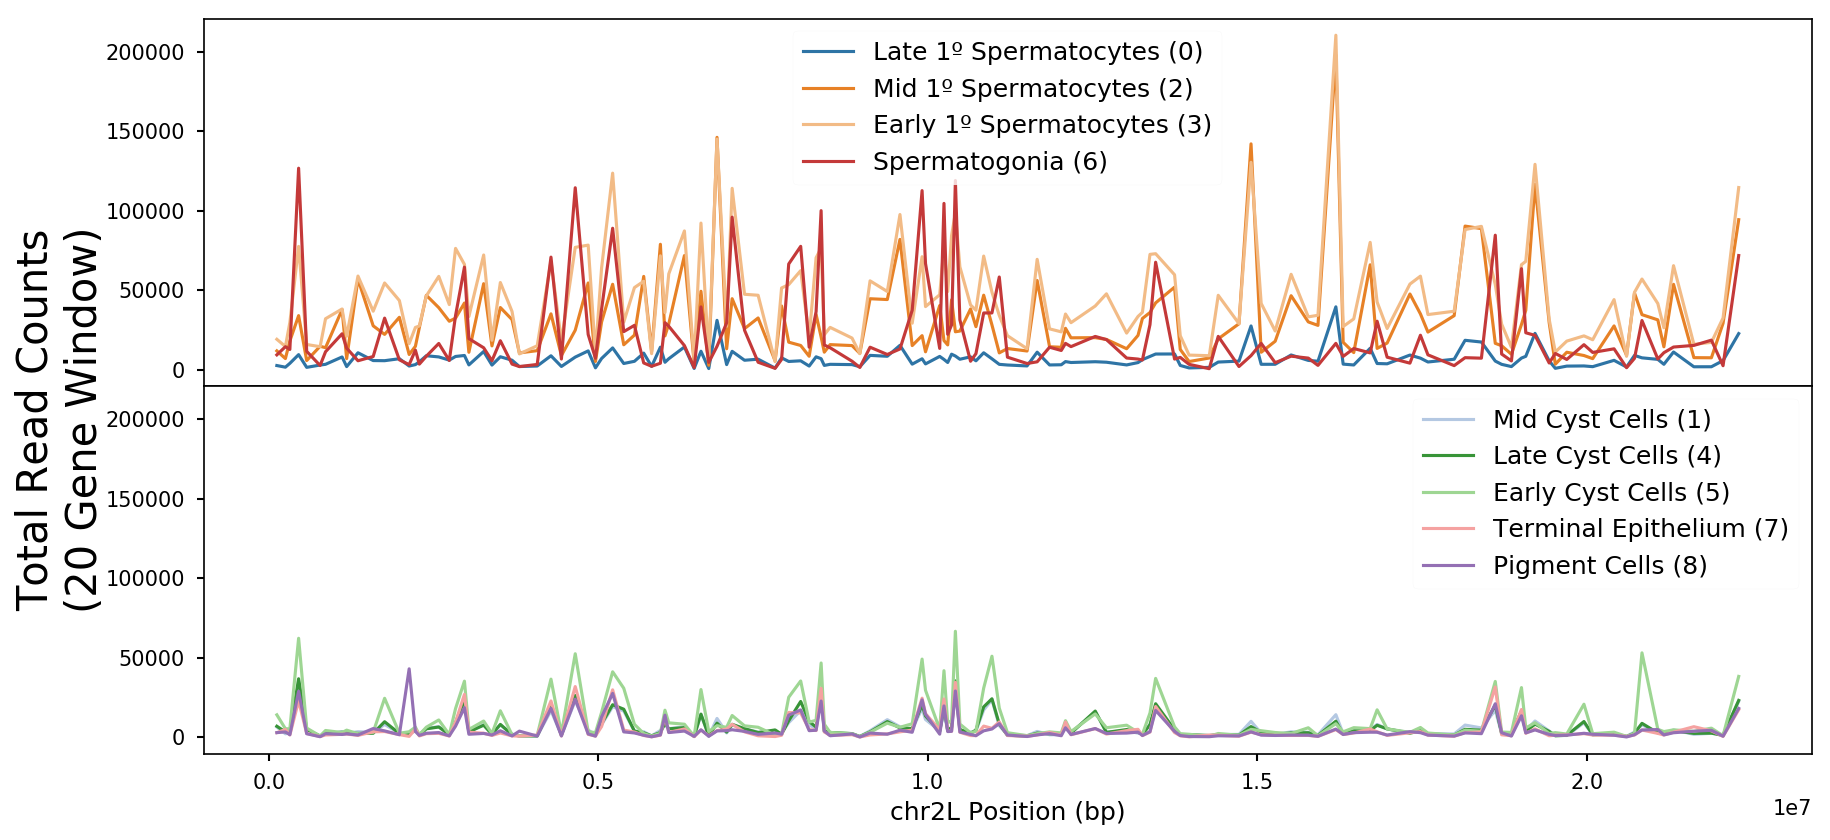

In [332]:
plot_chrom_pos(cbc, 'chr2L', ylabel='Total Read Counts\n(20 Gene Window)')

In [395]:
from larval_gonad.x_to_a import CHROMS_CHR

In [334]:

from glob import glob

lens = []
for fname in glob('../output/bulk-rnaseq-wf/rnaseq_samples/*/*.featurecounts.txt', recursive=True):
    lens.append(pd.read_csv(fname, skiprows=1, sep='\t', usecols=['Geneid', 'Length']))

gene_lens = pd.concat(lens).drop_duplicates()
gene_lens.columns = ['FBgn', 'gene_length']
gene_lens = gene_lens.set_index('FBgn').gene_length

tpm_norm = tpm(cbc, gene_lens[cbc.index])

Text(0,0.5,'Read Counts (Log TPM)')

/home/fearjm/miniconda3/envs/larval_gonad/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


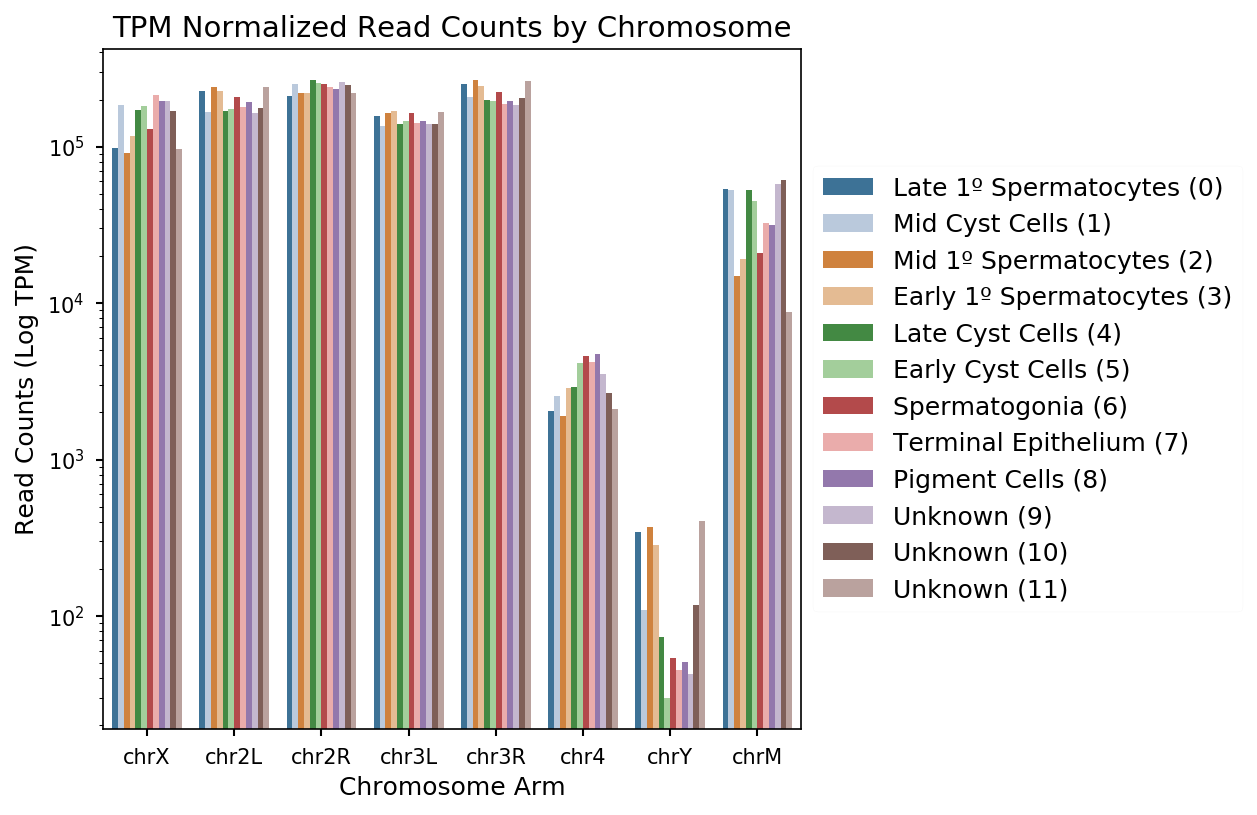

In [461]:
_tpm_norm = tpm_norm.rename(CLUSTER_ANNOT, axis=1)
_dat =  _tpm_norm.join(nbconfig.fbgn2chrom).groupby('chrom').sum().T
_dat = _dat.reset_index().melt(id_vars=['index'])
ax = sns.barplot('chrom', 'value', data=_dat, hue='index', palette=colors, order=CHROMS_CHR + ['chrM'])
ax.set_yscale('log')
ax.legend(loc='center left', bbox_to_anchor=[1, 0.5])
ax.set_title('TPM Normalized Read Counts by Chromosome')
ax.set_xlabel('Chromosome Arm')
ax.set_ylabel('Read Counts (Log TPM)')

Text(0.5,1,'Proportion Genes "Expressed"')

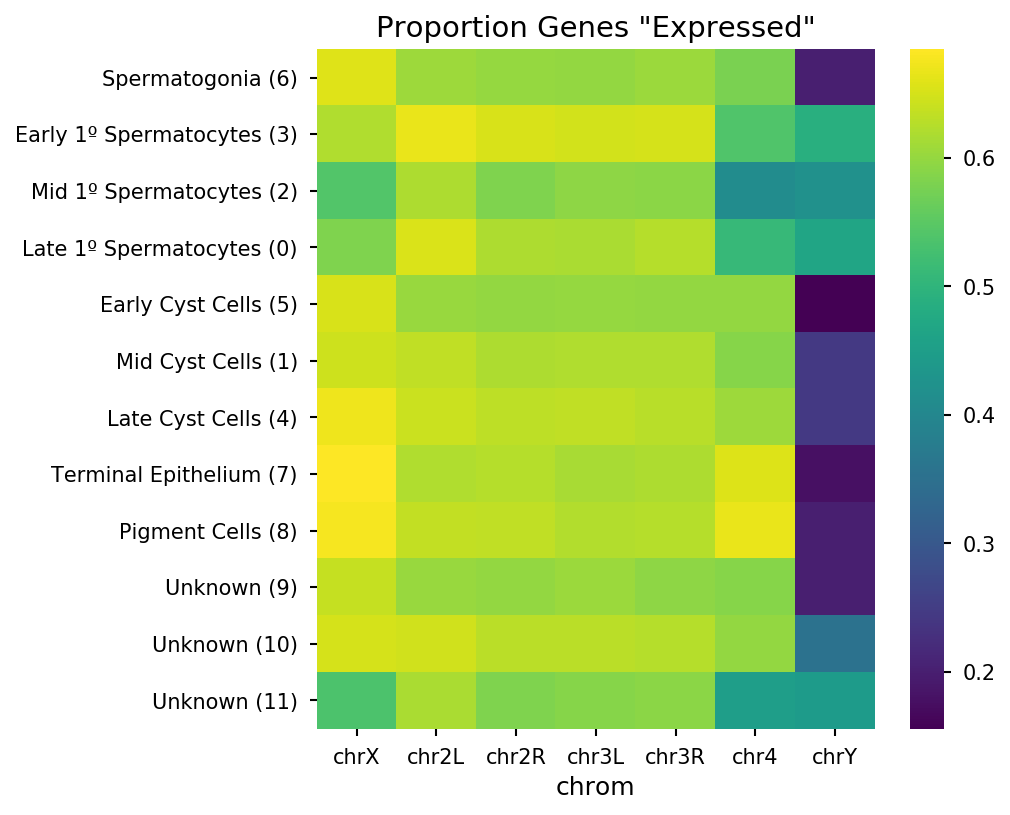

In [497]:
_on = (_tpm_norm > 1).join(nbconfig.fbgn2chrom).groupby('chrom').sum()
_tot =  (_tpm_norm > 1).join(nbconfig.fbgn2chrom).groupby('chrom').size()

ax = sns.heatmap(_on.div(_tot, axis='rows').T.loc[CLUSTER_ORDER, CHROMS_CHR], cmap='viridis')
ax.set_title('Proportion Genes "Expressed"')

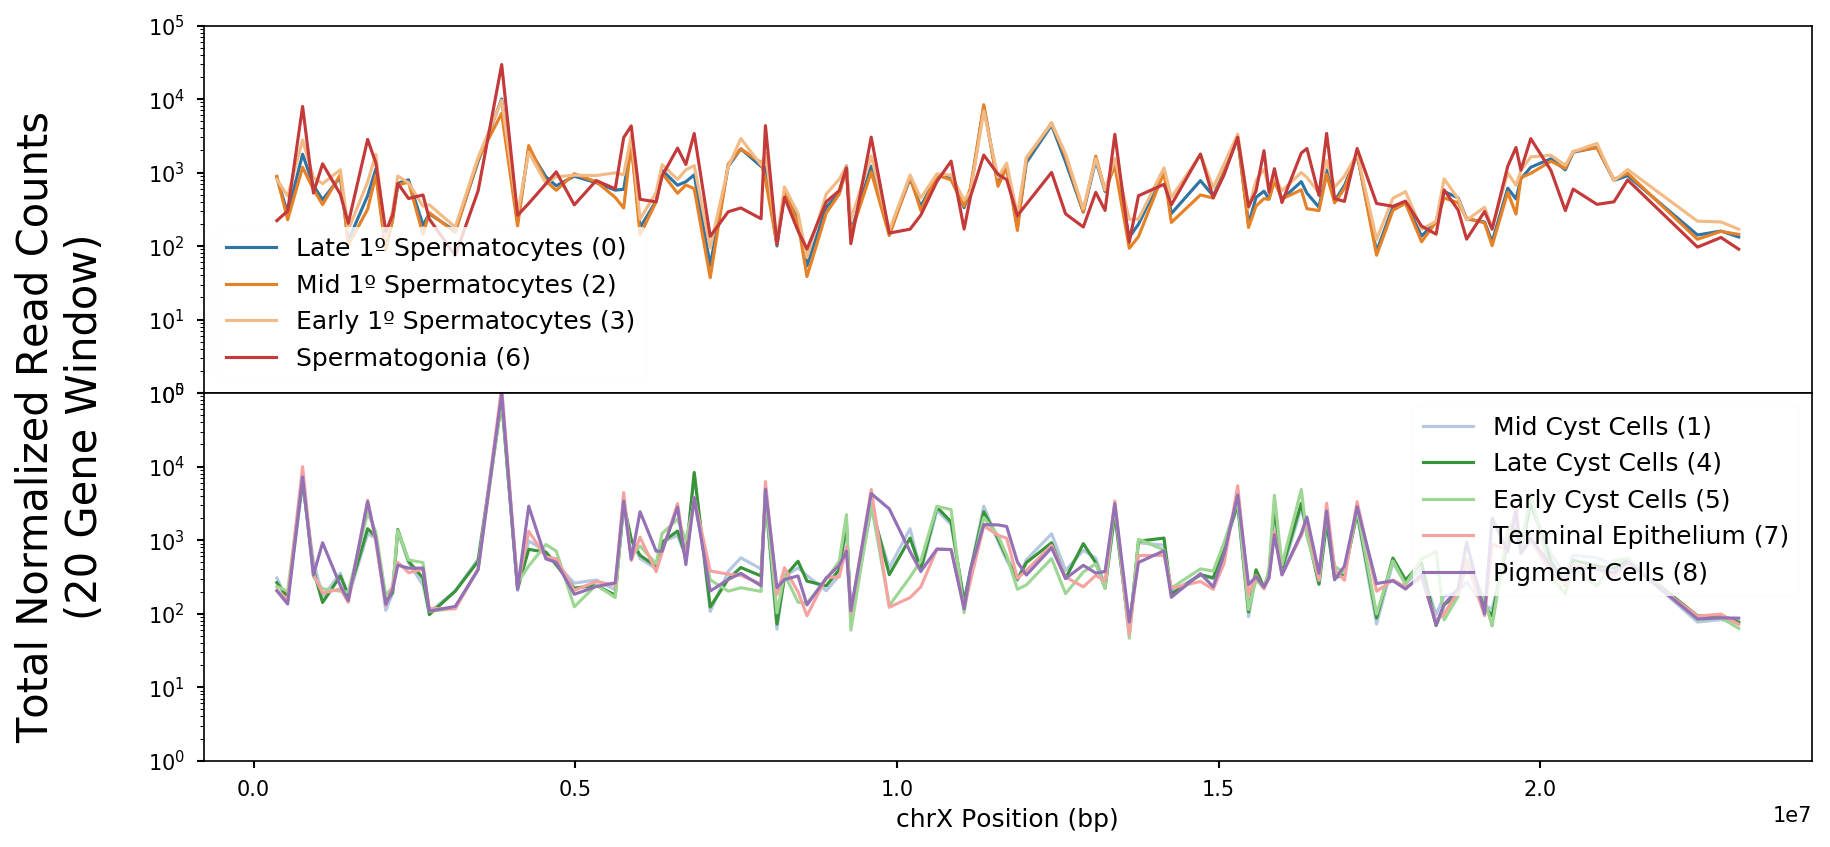

In [507]:
plot_chrom_pos(tpm_norm, 'chrX')
fig = plt.gcf()
for ax in fig.axes:
    ax.set_ylim(1, 100000)
    ax.set_yscale('log')

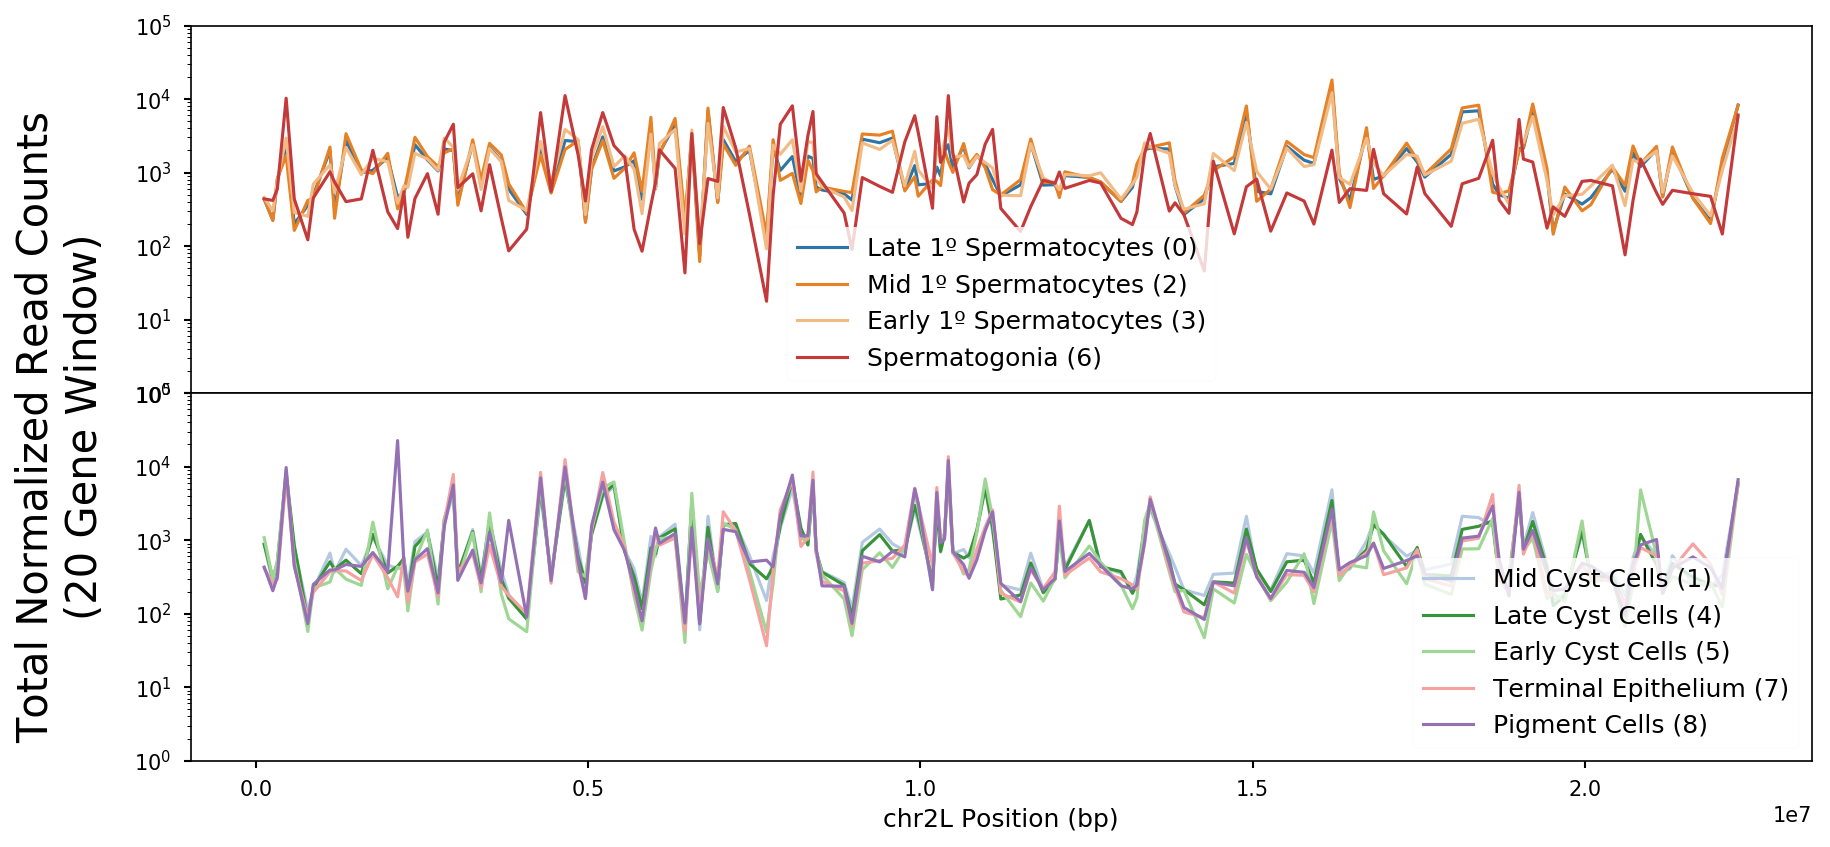

In [510]:
plot_chrom_pos(tpm_norm, 'chr2L')
fig = plt.gcf()
for ax in fig.axes:
    ax.set_ylim(1, 100000)
    ax.set_yscale('log')

Text(0.5,1,'Sum')

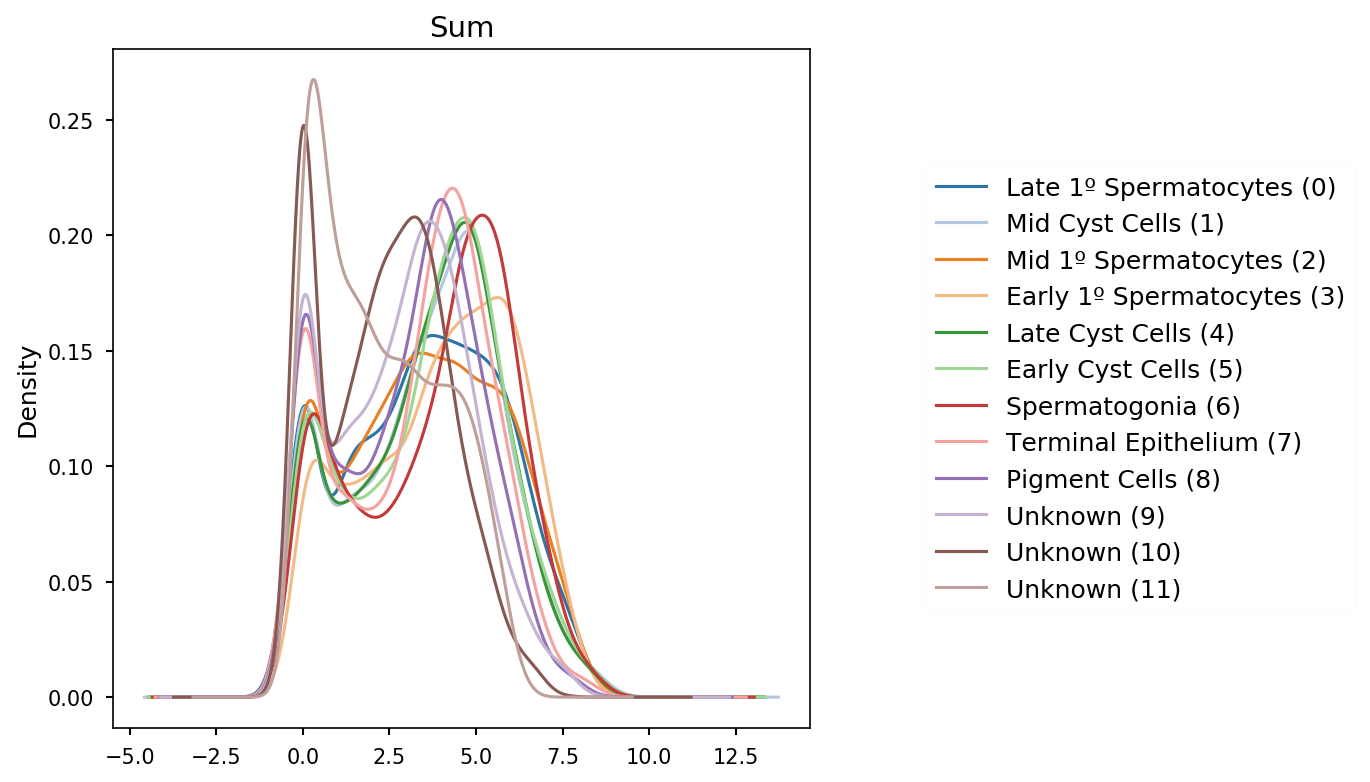

In [82]:
x = _sum.join(nbconfig.fbgn2chrom).query('chrom == "chrX"')
x.drop('chrom', inplace=True, axis=1)
x.columns = [CLUSTER_ANNOT[j] for j in x.columns]

ax = np.log1p(x).plot(kind='kde', color=colors)
ax.legend(loc='center right', bbox_to_anchor=[1.8, .5])
ax.set_title('Sum')

Text(0.5,1,'Fraction')

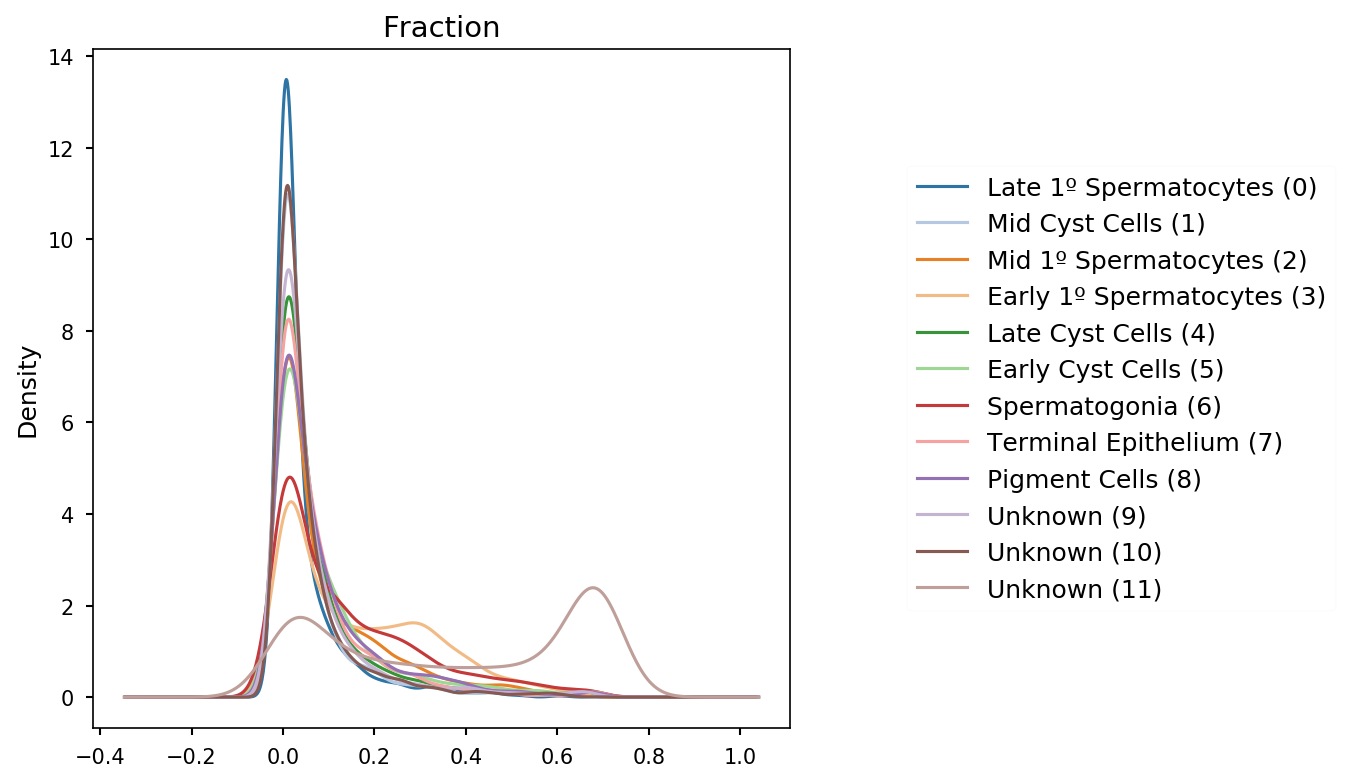

In [79]:
x = _frac_on.join(nbconfig.fbgn2chrom).query('chrom == "chrX"')
x.drop('chrom', inplace=True, axis=1)
x.columns = [CLUSTER_ANNOT[j] for j in x.columns]

ax = np.log1p(x).plot(kind='kde', color=colors)
ax.legend(loc='center right', bbox_to_anchor=[1.8, .5])
ax.set_title('Fraction')

In [90]:
(x > 0).sum() / x.shape[0]

Late 1º Spermatocytes (0)     0.873001
Mid Cyst Cells (1)            0.877113
Mid 1º Spermatocytes (2)      0.931019
Early 1º Spermatocytes (3)    0.969392
Late Cyst Cells (4)           0.883508
Early Cyst Cells (5)          0.901782
Spermatogonia (6)             0.924623
Terminal Epithelium (7)       0.841937
Pigment Cells (8)             0.851987
Unknown (9)                   0.840566
Unknown (10)                  0.776610
Unknown (11)                  0.957515
dtype: float64